In [7]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [8]:
!pip install bitsandbytes accelerate transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 26.7 MB/s eta 0:00:0000:0100:01m


In [9]:
import sys
import os
from typing import List, Tuple, Optional, Dict

from langchain_core.prompts import ChatPromptTemplate
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModelForSequenceClassification
import torch
from transformers import pipeline
import torch.nn as nn
from sentence_transformers import SentenceTransformer, util

2026-02-14 15:04:31.513448: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771081471.709016      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771081471.773914      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771081472.268944      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771081472.268982      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771081472.268985      55 computation_placer.cc:177] computation placer alr

In [26]:
"""
Complete Training Pipeline - All Issues Fixed
Extracts features from IBM dataset and prepares training data
"""

import sys
import os
from typing import List, Tuple, Optional, Dict
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import (
    AutoTokenizer, 
    AutoModelForCausalLM, 
    BitsAndBytesConfig,
    pipeline
)
from sentence_transformers import SentenceTransformer, util
from datasets import load_dataset
import gc
from tqdm import tqdm
from collections import Counter
import re


# ============================================================
# Model Provider
# ============================================================

class ModelProvider:
    def __init__(self, model_name: str):
        self.model_name = model_name
        self.tokenizer = None
        self.model = None
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
    
    def load(self):
        print(f"📥 Loading tokenizer: {self.model_name}")
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        
        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token
        
        print("⚡ Enabling 4-bit quantization...")
        bnb_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.float16,
            bnb_4bit_use_double_quant=True,
        )
        
        print("🧠 Loading model...")
        self.model = AutoModelForCausalLM.from_pretrained(
            self.model_name,
            quantization_config=bnb_config,
            device_map="auto",
            torch_dtype=torch.float16,
            low_cpu_mem_usage=True
        )
        
        print(f"✅ Model loaded on: {self.model.device}")
        return self
    
    def generate_with_logprobs(
        self, 
        prompt: str, 
        max_new_tokens: int = 40, 
        temperature: float = 0.7
    ):
        """Generate with logprobs and entropy"""
        
        # Clear cache
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            gc.collect()
        
        inputs = self.tokenizer(prompt, return_tensors="pt")
        input_ids = inputs["input_ids"].to(self.model.device)
        input_len = input_ids.shape[1]
        
        with torch.no_grad():
            outputs = self.model.generate(
                input_ids=input_ids,
                max_new_tokens=max_new_tokens,
                temperature=temperature,
                do_sample=True,
                return_dict_in_generate=True,
                output_scores=True,
                pad_token_id=self.tokenizer.pad_token_id
            )
        
        sequences = outputs.sequences[0]
        scores = outputs.scores
        
        # Decode
        full_text = self.tokenizer.decode(sequences, skip_special_tokens=True)
        decoded_prompt = self.tokenizer.decode(input_ids[0], skip_special_tokens=True)
        generated_text = full_text.replace(decoded_prompt, "").strip()
        
        # Compute logprobs and entropy
        logprobs = []
        entropies = []
        gen_token_ids = sequences[input_len:]
        
        for step_logits, token_id in zip(scores, gen_token_ids):
            logits = step_logits[0]
            
            # Logprob
            step_logprobs = F.log_softmax(logits, dim=-1)
            logprobs.append(step_logprobs[token_id].item())
            
            # Entropy
            probs = F.softmax(logits, dim=-1)
            entropy = -(probs * torch.log(probs + 1e-9)).sum()
            entropies.append(entropy.item())
        
        avg_logprob = sum(logprobs) / len(logprobs) if logprobs else 0.0
        max_logprob = max(logprobs) if logprobs else 0.0
        min_logprob = min(logprobs) if logprobs else 0.0
        avg_entropy = sum(entropies) / len(entropies) if entropies else 0.0
        
        return {
            "text": generated_text,
            "logprobs": logprobs,
            "avg_logprob": avg_logprob,
            "max_logprob": max_logprob,
            "min_logprob": min_logprob,
            "entropies": entropies,
            "avg_entropy": avg_entropy
        }


# ============================================================
# Helper Functions
# ============================================================

def nli_relevance_check(nli_pipeline, premise: str, hypothesis: str) -> Dict:
    """Check NLI relationship"""
    result = nli_pipeline(f"{premise} [SEP] {hypothesis}")
    return {
        "label": result[0]['label'],
        "score": result[0]['score']
    }


def calculate_repetition_score(text: str, n: int = 3) -> float:
    """
    Compute n-gram repetition score
    
    Returns:
        score in [0,1] where 0=no repetition, 1=extreme repetition
    """
    text = text.lower()
    tokens = re.findall(r"\b\w+\b", text)
    
    if len(tokens) < n:
        return 0.0
    
    # Build n-grams
    ngrams = [tuple(tokens[i:i+n]) for i in range(len(tokens) - n + 1)]
    
    if len(ngrams) == 0:
        return 0.0
    
    counts = Counter(ngrams)
    total_ngrams = len(ngrams)
    repeated_ngrams = sum(freq - 1 for freq in counts.values() if freq > 1)
    
    score = repeated_ngrams / total_ngrams
    return float(score)


def similarity_check(similarity_model, text1: str, text2: str) -> float:
    """Compute semantic similarity"""
    embeddings = similarity_model.encode([text1, text2], convert_to_tensor=True)
    cosine_score = util.cos_sim(embeddings[0], embeddings[1])
    scaled_score = (cosine_score.item() + 1) / 2
    return scaled_score


def supporting_argument_node(state: Dict, model_provider) -> Dict:
    """Generate supporting argument"""
    topic = state["topic"]
    
    prompt = f"""You are a skilled debater. Generate a strong supporting argument for this topic.

Topic: {topic}

Generate a clear, logical argument IN SUPPORT of this topic.

Argument:"""
    
    result = model_provider.generate_with_logprobs(prompt)
    
    return {
        "argument": result["text"],
        "logprobs": result["logprobs"],
        "avg_logprob": result["avg_logprob"],
        "max_logprob": result.get("max_logprob", 0.0),
        "min_logprob": result.get("min_logprob", 0.0),
        "avg_entropy": result.get("avg_entropy", 0.0)
    }


def opposing_argument_node(state: Dict, model_provider) -> Dict:
    """Generate opposing argument"""
    topic = state["topic"]
    
    prompt = f"""You are a skilled debater. Generate a strong opposing argument for this topic.

Topic: {topic}

Generate a clear, logical argument AGAINST this topic.

Argument:"""
    
    result = model_provider.generate_with_logprobs(prompt)
    
    return {
        "argument": result["text"],
        "logprobs": result["logprobs"],
        "avg_logprob": result["avg_logprob"]
    }


# ============================================================
# Confidence Score Calculator
# ============================================================

HEDGING_WORDS = {
    'strong': {
        'may be', 'might be', 'could be', 'would be', 'perhaps', 'possibly',
        'maybe', 'uncertain', 'unclear', 'questionable', 'debatable',
        'arguably', 'supposedly', 'allegedly', 'presumably', 'conceivably',
        'potentially', 'seems like', 'appears to be', 'looks like',
        'i think', 'i believe', 'i guess', 'i suppose', 'in my opinion',
        'not sure', 'unsure', 'doubt', 'speculation', 'speculative'
    },
    'moderate': {
        'likely', 'probably', 'generally', 'typically', 'usually',
        'often', 'sometimes', 'occasionally', 'frequently', 'tend to',
        'appear to', 'seem to', 'suggest', 'indicate', 'imply',
        'somewhat', 'rather', 'quite', 'fairly', 'relatively',
        'to some extent', 'to a degree', 'in some ways', 'partially',
        'might', 'could', 'would', 'should', 'may'
    },
    'weak': {
        'possible', 'feasible', 'plausible', 'reasonable', 'viable',
        'can', 'will', 'shall', 'mostly', 'largely',
        'predominantly', 'mainly', 'chiefly', 'primarily'
    }
}

CONFIDENCE_BOOSTERS = {
    'certainly', 'definitely', 'absolutely', 'clearly', 'obviously',
    'undoubtedly', 'unquestionably', 'indisputably', 'surely', 'indeed',
    'proven', 'demonstrated', 'established', 'confirmed', 'verified',
    'conclusively', 'decidedly', 'precisely', 'exactly', 'specifically',
    'must', 'will', 'always', 'never', 'all', 'none', 'every',
    'inevitable', 'certain', 'guaranteed', 'assured', 'definite',
    'fact', 'facts', 'evidence shows', 'research proves', 'studies show'
}

QUALIFIERS = {
    'kind of', 'sort of', 'a bit', 'a little', 'slightly', 'somewhat',
    'more or less', 'in a sense', 'in a way', 'so to speak',
    'basically', 'essentially', 'roughly', 'approximately', 'around'
}

QUESTION_MARKERS = {
    'is it', 'are there', 'could it be', 'might it be', 'what if',
    'how can', 'why would', 'who knows', 'remains to be seen'
}


def _count_phrases(text: str, phrase_set: set) -> int:
    """Count occurrences of phrases in text"""
    count = 0
    for phrase in phrase_set:
        pattern = r'\b' + re.escape(phrase) + r'\b'
        count += len(re.findall(pattern, text))
    return count


def calculate_confidence_score(text: str) -> Dict[str, float]:
    """Calculate confidence score based on linguistic markers"""
    text_lower = text.lower()
    words = text_lower.split()
    total_words = len(words)
    
    if total_words == 0:
        return {'confidence_score': 0.5, 'details': {}}
    
    # Count markers
    strong_hedge_count = _count_phrases(text_lower, HEDGING_WORDS['strong'])
    moderate_hedge_count = _count_phrases(text_lower, HEDGING_WORDS['moderate'])
    weak_hedge_count = _count_phrases(text_lower, HEDGING_WORDS['weak'])
    
    booster_count = _count_phrases(text_lower, CONFIDENCE_BOOSTERS)
    qualifier_count = _count_phrases(text_lower, QUALIFIERS)
    question_count = _count_phrases(text_lower, QUESTION_MARKERS)
    
    # Calculate scores
    hedge_score = (
        strong_hedge_count * 3.0 +
        moderate_hedge_count * 2.0 +
        weak_hedge_count * 1.0 +
        qualifier_count * 1.5 +
        question_count * 2.0
    )
    
    normalized_hedge_score = (hedge_score / total_words) * 100
    normalized_booster_score = (booster_count / total_words) * 100
    
    base_confidence = 0.5
    hedge_penalty = min(normalized_hedge_score * 0.05, 0.4)
    booster_bonus = min(normalized_booster_score * 0.1, 0.4)
    
    confidence_score = base_confidence - hedge_penalty + booster_bonus
    confidence_score = max(0.0, min(1.0, confidence_score))
    
    details = {
        'strong_hedges': strong_hedge_count,
        'moderate_hedges': moderate_hedge_count,
        'weak_hedges': weak_hedge_count,
        'confidence_boosters': booster_count,
        'hedge_penalty': hedge_penalty,
        'booster_bonus': booster_bonus
    }
    
    return {
        'confidence_score': confidence_score,
        'details': details
    }


# ============================================================
# Feature Extractor
# ============================================================

class FeatureExtractor:
    """Extract features for training"""
    
    def __init__(self):
        self.device_id = 0 if torch.cuda.is_available() else -1
        self.device_str = "cuda" if torch.cuda.is_available() else "cpu"
        print(f"🚀 FeatureExtractor using device: {self.device_str}")
        
        print("📦 Loading NLI pipeline...")
        self.nli_pipeline = pipeline(
            "text-classification",
            model="facebook/bart-large-mnli",
            device=self.device_id
        )
        
        print("📦 Loading similarity model...")
        self.similarity_model = SentenceTransformer(
            "all-MiniLM-L6-v2",
            device=self.device_str
        )
        
        print("📦 Initializing Model Provider...")
        self.model_provider = ModelProvider(
            model_name="mistralai/Mistral-7B-Instruct-v0.1"
        )
        print("📥 Loading Model Weights & Tokenizer...")
        self.model_provider.load()
        
        print("✅ FeatureExtractor ready!")
    
    def extract_features(self, topic: str) -> Dict:
        """Extract all features for a topic"""
        
        # Generate arguments
        supporting_result = supporting_argument_node(
            {"topic": topic},
            self.model_provider
        )
        
        opposing_result = opposing_argument_node(
            {"topic": topic},
            self.model_provider
        )
        
        argument = supporting_result["argument"]
        opposing_argument = opposing_result["argument"]
        
        # Logprob features
        avg_logprob = supporting_result["avg_logprob"]
        max_logprob = supporting_result.get("max_logprob", 0.0)
        min_logprob = supporting_result.get("min_logprob", 0.0)
        avg_entropy = supporting_result.get("avg_entropy", 0.0)
        
        # NLI features
        relevance_result = nli_relevance_check(
            self.nli_pipeline,
            topic,
            argument
        )
        
        if relevance_result["label"] == "ENTAILMENT":
            relevance_score_support = relevance_result["score"]
        elif relevance_result["label"] == "CONTRADICTION":
            relevance_score_support = 0.0
        else:
            relevance_score_support = 1 - relevance_result["score"]
        
        relevance_result2 = nli_relevance_check(
            self.nli_pipeline,
            argument,
            opposing_argument
        )
        
        if relevance_result2["label"] == "ENTAILMENT":
            relevance_score_contra = 1 - relevance_result2["score"]
        elif relevance_result2["label"] == "NEUTRAL":
            relevance_score_contra = 0.5
        else:
            relevance_score_contra = relevance_result2["score"]
        
        # Semantic similarity
        similarity_score = similarity_check(
            self.similarity_model,
            topic,
            argument
        )
        
        # Confidence and repetition
        confidence_result = calculate_confidence_score(argument)
        confidence_score = confidence_result['confidence_score']
        
        repetition_score = calculate_repetition_score(argument)
        
        return {
            "avg_logprob": avg_logprob,
            "max_logprob": max_logprob,
            "min_logprob": min_logprob,
            "avg_entropy": avg_entropy,
            "relevance_score_support": relevance_score_support,
            "relevance_score_contra": relevance_score_contra,
            "similarity_score": similarity_score,
            "confidence_score": confidence_score,
            "repitition_score": repetition_score
        }


# ============================================================
# Data Preparation
# ============================================================

def prepare_data(
    dataset,
    feature_extractor: FeatureExtractor,
    max_samples: int = 1000,
    save_path: Optional[str] = "training_data.pt",
    start_idx: int = 0
) -> List[Tuple[torch.Tensor, float]]:
    """Prepare training data with resume support"""
    
    # Resume logic
    if start_idx > 0 and os.path.exists(save_path):
        training_data = torch.load(save_path)
        print(f"🔁 Loaded checkpoint with {len(training_data)} samples")
    else:
        training_data = []
        print("🆕 Starting fresh dataset")
    
    print(f"\n🔧 Processing samples {start_idx} → {max_samples}")
    
    for i in tqdm(range(start_idx, min(max_samples, len(dataset)))):
        try:
            entry = dataset[i]
            
            topic = entry.get("topic", "")
            if not topic:
                print(f"⚠️ Skipping {i}: no topic")
                continue
            
            # Extract features
            features_dict = feature_extractor.extract_features(topic)
            
            # Create feature tensor (4 features for now)
            features = torch.tensor([
                features_dict["avg_logprob"],
                features_dict["relevance_score_support"],
                features_dict["relevance_score_contra"],
                features_dict["similarity_score"],
                features_dict["confidence_score"],
                features_dict["repitition_score"],
                features_dict["max_logprob"],
                features_dict["min_logprob"],
                features_dict["avg_entropy"]
                
            ], dtype=torch.float32)
            
            # Ground truth: (WA * stance_WA + 1) / 2 to normalize to [0,1]
            wa = entry.get("WA", 0.5)
            stance_wa = entry.get("stance_WA", 0.5)
            truth_score = ((wa * stance_wa) + 1) / 2.0
            
            training_data.append((features, truth_score))
            
            # Logging
            if (i + 1) % 25 == 0:
                print(f"\n✅ Processed {i+1}/{max_samples}")
                print(f"   Topic: {topic[:50]}...")
                print(f"   Label: {truth_score:.3f}")
            
            # Checkpoint save
            if (i + 1) % 3 == 0 and save_path:
                torch.save(training_data, save_path)
                print(f"💾 Checkpoint @ {i+1}")
        
        except Exception as e:
            print(f"\n❌ Error at {i}: {e}")
            import traceback
            traceback.print_exc()
            continue
    
    # Final save
    if save_path:
        torch.save(training_data, save_path)
        print(f"\n💾 Final save → {save_path}")
    
    print(f"✅ Total samples: {len(training_data)}")
    
    return training_data


# ============================================================
# Main Execution
# ============================================================

if __name__ == "__main__":
    
    print("🧠 Training Data Preparation Pipeline")
    print("=" * 80)
    
    # Load dataset
    print("\n📦 Loading IBM dataset...")
    try:
        ds = load_dataset(
            "ibm-research/argument_quality_ranking_30k",
            "argument_quality_ranking"
        )
        print("✅ Dataset loaded!")
        print(f"   Train: {len(ds['train'])} samples")
        print(f"   Validation: {len(ds['validation'])} samples")
    except Exception as e:
        print(f"❌ Error: {e}")
        print("💡 Run: huggingface-cli login")
        exit(1)
    
    # Initialize
    print("\n🔧 Initializing Feature Extractor...")
    feature_extractor = FeatureExtractor()
    
    # Prepare data
    print("\n📝 Starting data preparation...")
    
    training_data = prepare_data(
        dataset=ds["train"],
        feature_extractor=feature_extractor,
        max_samples=1000,  # Start small
        save_path="training_data.pt",
        start_idx=0
    )
    
    # Analyze
    if training_data:
        features = torch.stack([item[0] for item in training_data])
        labels = torch.tensor([item[1] for item in training_data])
        
        print("\n📊 Data Statistics:")
        print(f"   Samples: {len(training_data)}")
        print(f"\n   Feature Means:")
        print(f"      Logprob: {features[:, 0].mean():.3f}")
        print(f"      Relevance (Support): {features[:, 1].mean():.3f}")
        print(f"      Relevance (Contra): {features[:, 2].mean():.3f}")
        print(f"      Similarity: {features[:, 3].mean():.3f}")
        print(f"\n   Label Statistics:")
        print(f"      Mean: {labels.mean():.3f}")
        print(f"      Std: {labels.std():.3f}")
        print(f"      Min: {labels.min():.3f}")
        print(f"      Max: {labels.max():.3f}")
    
    print("\n✅ COMPLETE!")

🧠 Training Data Preparation Pipeline

📦 Loading IBM dataset...
✅ Dataset loaded!
   Train: 20974 samples
   Validation: 3208 samples

🔧 Initializing Feature Extractor...
🚀 FeatureExtractor using device: cuda
📦 Loading NLI pipeline...


Device set to use cuda:0


📦 Loading similarity model...
📦 Initializing Model Provider...
📥 Loading Model Weights & Tokenizer...
📥 Loading tokenizer: mistralai/Mistral-7B-Instruct-v0.1
⚡ Enabling 4-bit quantization...
🧠 Loading model...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

✅ Model loaded on: cuda:0
✅ FeatureExtractor ready!

📝 Starting data preparation...
🆕 Starting fresh dataset

🔧 Processing samples 0 → 1000


  0%|          | 3/1000 [00:26<2:25:44,  8.77s/it]

💾 Checkpoint @ 3


  1%|          | 6/1000 [00:52<2:23:19,  8.65s/it]

💾 Checkpoint @ 6


  1%|          | 9/1000 [01:18<2:22:38,  8.64s/it]

💾 Checkpoint @ 9


  1%|          | 12/1000 [01:44<2:21:52,  8.62s/it]

💾 Checkpoint @ 12


  2%|▏         | 15/1000 [02:09<2:21:30,  8.62s/it]

💾 Checkpoint @ 15


  2%|▏         | 18/1000 [02:35<2:21:09,  8.62s/it]

💾 Checkpoint @ 18


  2%|▏         | 21/1000 [03:01<2:20:26,  8.61s/it]

💾 Checkpoint @ 21


  2%|▏         | 24/1000 [03:27<2:20:03,  8.61s/it]

💾 Checkpoint @ 24


  2%|▎         | 25/1000 [03:35<2:19:39,  8.59s/it]


✅ Processed 25/1000
   Topic: We should introduce compulsory voting...
   Label: 0.820


  3%|▎         | 27/1000 [03:52<2:18:38,  8.55s/it]

💾 Checkpoint @ 27


  3%|▎         | 30/1000 [04:18<2:18:26,  8.56s/it]

💾 Checkpoint @ 30


  3%|▎         | 33/1000 [04:44<2:17:54,  8.56s/it]

💾 Checkpoint @ 33


  4%|▎         | 36/1000 [05:10<2:17:43,  8.57s/it]

💾 Checkpoint @ 36


  4%|▍         | 39/1000 [05:35<2:17:09,  8.56s/it]

💾 Checkpoint @ 39


  4%|▍         | 42/1000 [06:01<2:16:39,  8.56s/it]

💾 Checkpoint @ 42


  4%|▍         | 45/1000 [06:27<2:16:42,  8.59s/it]

💾 Checkpoint @ 45


  5%|▍         | 48/1000 [06:52<2:16:08,  8.58s/it]

💾 Checkpoint @ 48


  5%|▌         | 50/1000 [07:10<2:15:42,  8.57s/it]


✅ Processed 50/1000
   Topic: We should subsidize Wikipedia...
   Label: 0.000


  5%|▌         | 51/1000 [07:18<2:15:24,  8.56s/it]

💾 Checkpoint @ 51


  5%|▌         | 54/1000 [07:44<2:14:57,  8.56s/it]

💾 Checkpoint @ 54


  6%|▌         | 57/1000 [08:09<2:14:47,  8.58s/it]

💾 Checkpoint @ 57


  6%|▌         | 60/1000 [08:35<2:14:25,  8.58s/it]

💾 Checkpoint @ 60


  6%|▋         | 63/1000 [09:01<2:13:32,  8.55s/it]

💾 Checkpoint @ 63


  7%|▋         | 66/1000 [09:27<2:13:34,  8.58s/it]

💾 Checkpoint @ 66


  7%|▋         | 69/1000 [09:52<2:13:14,  8.59s/it]

💾 Checkpoint @ 69


  7%|▋         | 72/1000 [10:18<2:13:47,  8.65s/it]

💾 Checkpoint @ 72


  8%|▊         | 75/1000 [10:44<2:12:54,  8.62s/it]


✅ Processed 75/1000
   Topic: We should oppose collectivism...
   Label: 0.128
💾 Checkpoint @ 75


  8%|▊         | 78/1000 [11:10<2:13:35,  8.69s/it]

💾 Checkpoint @ 78


  8%|▊         | 81/1000 [11:37<2:13:31,  8.72s/it]

💾 Checkpoint @ 81


  8%|▊         | 84/1000 [12:03<2:13:18,  8.73s/it]

💾 Checkpoint @ 84


  9%|▊         | 87/1000 [12:29<2:11:35,  8.65s/it]

💾 Checkpoint @ 87


  9%|▉         | 90/1000 [12:55<2:10:57,  8.63s/it]

💾 Checkpoint @ 90


  9%|▉         | 93/1000 [13:21<2:10:58,  8.66s/it]

💾 Checkpoint @ 93


 10%|▉         | 96/1000 [13:46<2:09:51,  8.62s/it]

💾 Checkpoint @ 96


 10%|▉         | 99/1000 [14:12<2:09:05,  8.60s/it]

💾 Checkpoint @ 99


 10%|█         | 100/1000 [14:21<2:08:59,  8.60s/it]


✅ Processed 100/1000
   Topic: We should ban cosmetic surgery for minors...
   Label: 0.924


 10%|█         | 102/1000 [14:38<2:08:29,  8.58s/it]

💾 Checkpoint @ 102


 10%|█         | 105/1000 [15:04<2:08:16,  8.60s/it]

💾 Checkpoint @ 105


 11%|█         | 108/1000 [15:30<2:07:27,  8.57s/it]

💾 Checkpoint @ 108


 11%|█         | 111/1000 [15:55<2:07:09,  8.58s/it]

💾 Checkpoint @ 111


 11%|█▏        | 114/1000 [16:21<2:06:54,  8.59s/it]

💾 Checkpoint @ 114


 12%|█▏        | 117/1000 [16:47<2:06:35,  8.60s/it]

💾 Checkpoint @ 117


 12%|█▏        | 120/1000 [17:13<2:06:08,  8.60s/it]

💾 Checkpoint @ 120


 12%|█▏        | 123/1000 [17:38<2:05:26,  8.58s/it]

💾 Checkpoint @ 123


 12%|█▎        | 125/1000 [17:56<2:05:28,  8.60s/it]


✅ Processed 125/1000
   Topic: We should adopt a multi-party system...
   Label: 0.986


 13%|█▎        | 126/1000 [18:04<2:05:20,  8.61s/it]

💾 Checkpoint @ 126


 13%|█▎        | 129/1000 [18:30<2:05:11,  8.62s/it]

💾 Checkpoint @ 129


 13%|█▎        | 132/1000 [18:56<2:04:39,  8.62s/it]

💾 Checkpoint @ 132


 14%|█▎        | 135/1000 [19:22<2:04:02,  8.60s/it]

💾 Checkpoint @ 135


 14%|█▍        | 138/1000 [19:48<2:03:21,  8.59s/it]

💾 Checkpoint @ 138


 14%|█▍        | 141/1000 [20:13<2:02:59,  8.59s/it]

💾 Checkpoint @ 141


 14%|█▍        | 144/1000 [20:39<2:02:34,  8.59s/it]

💾 Checkpoint @ 144


 15%|█▍        | 147/1000 [21:05<2:02:24,  8.61s/it]

💾 Checkpoint @ 147


 15%|█▌        | 150/1000 [21:31<2:02:11,  8.62s/it]


✅ Processed 150/1000
   Topic: We should adopt a multi-party system...
   Label: 0.941
💾 Checkpoint @ 150


 15%|█▌        | 153/1000 [21:57<2:01:31,  8.61s/it]

💾 Checkpoint @ 153


 16%|█▌        | 156/1000 [22:22<2:00:50,  8.59s/it]

💾 Checkpoint @ 156


 16%|█▌        | 159/1000 [22:48<2:00:18,  8.58s/it]

💾 Checkpoint @ 159


 16%|█▌        | 162/1000 [23:14<2:00:17,  8.61s/it]

💾 Checkpoint @ 162


 16%|█▋        | 165/1000 [23:40<2:00:00,  8.62s/it]

💾 Checkpoint @ 165


 17%|█▋        | 168/1000 [24:06<1:59:30,  8.62s/it]

💾 Checkpoint @ 168


 17%|█▋        | 171/1000 [24:32<1:59:08,  8.62s/it]

💾 Checkpoint @ 171


 17%|█▋        | 174/1000 [24:58<1:58:44,  8.63s/it]

💾 Checkpoint @ 174


 18%|█▊        | 175/1000 [25:06<1:58:30,  8.62s/it]


✅ Processed 175/1000
   Topic: We should adopt a multi-party system...
   Label: 0.031


 18%|█▊        | 177/1000 [25:23<1:57:45,  8.59s/it]

💾 Checkpoint @ 177


 18%|█▊        | 180/1000 [25:49<1:57:42,  8.61s/it]

💾 Checkpoint @ 180


 18%|█▊        | 183/1000 [26:15<1:57:11,  8.61s/it]

💾 Checkpoint @ 183


 19%|█▊        | 186/1000 [26:41<1:56:40,  8.60s/it]

💾 Checkpoint @ 186


 19%|█▉        | 189/1000 [27:06<1:56:23,  8.61s/it]

💾 Checkpoint @ 189


 19%|█▉        | 192/1000 [27:32<1:55:48,  8.60s/it]

💾 Checkpoint @ 192


 20%|█▉        | 195/1000 [27:58<1:55:08,  8.58s/it]

💾 Checkpoint @ 195


 20%|█▉        | 198/1000 [28:24<1:54:58,  8.60s/it]

💾 Checkpoint @ 198


 20%|██        | 200/1000 [28:41<1:54:34,  8.59s/it]


✅ Processed 200/1000
   Topic: We should adopt a multi-party system...
   Label: 0.069


 20%|██        | 201/1000 [28:50<1:54:13,  8.58s/it]

💾 Checkpoint @ 201


 20%|██        | 204/1000 [29:15<1:54:21,  8.62s/it]

💾 Checkpoint @ 204


 21%|██        | 207/1000 [29:41<1:53:32,  8.59s/it]

💾 Checkpoint @ 207


 21%|██        | 210/1000 [30:07<1:52:56,  8.58s/it]

💾 Checkpoint @ 210


 21%|██▏       | 213/1000 [30:33<1:52:15,  8.56s/it]

💾 Checkpoint @ 213


 22%|██▏       | 216/1000 [30:58<1:52:11,  8.59s/it]

💾 Checkpoint @ 216


 22%|██▏       | 219/1000 [31:24<1:52:08,  8.62s/it]

💾 Checkpoint @ 219


 22%|██▏       | 222/1000 [31:50<1:51:20,  8.59s/it]

💾 Checkpoint @ 222


 22%|██▎       | 225/1000 [32:16<1:51:26,  8.63s/it]


✅ Processed 225/1000
   Topic: We should adopt a multi-party system...
   Label: 0.947
💾 Checkpoint @ 225


 23%|██▎       | 228/1000 [32:42<1:50:58,  8.63s/it]

💾 Checkpoint @ 228


 23%|██▎       | 231/1000 [33:07<1:50:16,  8.60s/it]

💾 Checkpoint @ 231


 23%|██▎       | 234/1000 [33:33<1:50:02,  8.62s/it]

💾 Checkpoint @ 234


 24%|██▎       | 237/1000 [33:59<1:49:37,  8.62s/it]

💾 Checkpoint @ 237


 24%|██▍       | 240/1000 [34:25<1:49:09,  8.62s/it]

💾 Checkpoint @ 240


 24%|██▍       | 243/1000 [34:51<1:48:32,  8.60s/it]

💾 Checkpoint @ 243


 25%|██▍       | 246/1000 [35:17<1:47:50,  8.58s/it]

💾 Checkpoint @ 246


 25%|██▍       | 249/1000 [35:42<1:47:10,  8.56s/it]

💾 Checkpoint @ 249


 25%|██▌       | 250/1000 [35:51<1:47:15,  8.58s/it]


✅ Processed 250/1000
   Topic: We should abolish the right to keep and bear arms...
   Label: 0.301


 25%|██▌       | 252/1000 [36:08<1:47:04,  8.59s/it]

💾 Checkpoint @ 252


 26%|██▌       | 255/1000 [36:34<1:46:44,  8.60s/it]

💾 Checkpoint @ 255


 26%|██▌       | 258/1000 [37:00<1:46:02,  8.57s/it]

💾 Checkpoint @ 258


 26%|██▌       | 261/1000 [37:25<1:45:49,  8.59s/it]

💾 Checkpoint @ 261


 26%|██▋       | 264/1000 [37:51<1:45:27,  8.60s/it]

💾 Checkpoint @ 264


 27%|██▋       | 267/1000 [38:17<1:44:47,  8.58s/it]

💾 Checkpoint @ 267


 27%|██▋       | 270/1000 [38:42<1:44:19,  8.57s/it]

💾 Checkpoint @ 270


 27%|██▋       | 273/1000 [39:08<1:44:16,  8.61s/it]

💾 Checkpoint @ 273


 28%|██▊       | 275/1000 [39:26<1:44:07,  8.62s/it]


✅ Processed 275/1000
   Topic: We should abolish safe spaces...
   Label: 0.177


 28%|██▊       | 276/1000 [39:34<1:43:41,  8.59s/it]

💾 Checkpoint @ 276


 28%|██▊       | 279/1000 [40:00<1:43:02,  8.58s/it]

💾 Checkpoint @ 279


 28%|██▊       | 282/1000 [40:26<1:42:44,  8.59s/it]

💾 Checkpoint @ 282


 28%|██▊       | 285/1000 [40:51<1:42:24,  8.59s/it]

💾 Checkpoint @ 285


 29%|██▉       | 288/1000 [41:17<1:41:52,  8.58s/it]

💾 Checkpoint @ 288


 29%|██▉       | 291/1000 [41:43<1:41:12,  8.57s/it]

💾 Checkpoint @ 291


 29%|██▉       | 294/1000 [42:09<1:41:04,  8.59s/it]

💾 Checkpoint @ 294


 30%|██▉       | 297/1000 [42:35<1:40:51,  8.61s/it]

💾 Checkpoint @ 297


 30%|███       | 300/1000 [43:00<1:40:30,  8.61s/it]


✅ Processed 300/1000
   Topic: We should stop the development of autonomous cars...
   Label: 0.138
💾 Checkpoint @ 300


 30%|███       | 303/1000 [43:26<1:40:10,  8.62s/it]

💾 Checkpoint @ 303


 31%|███       | 306/1000 [43:52<1:39:21,  8.59s/it]

💾 Checkpoint @ 306


 31%|███       | 309/1000 [44:18<1:39:38,  8.65s/it]

💾 Checkpoint @ 309


 31%|███       | 312/1000 [44:44<1:39:19,  8.66s/it]

💾 Checkpoint @ 312


 32%|███▏      | 315/1000 [45:10<1:38:33,  8.63s/it]

💾 Checkpoint @ 315


 32%|███▏      | 318/1000 [45:36<1:38:18,  8.65s/it]

💾 Checkpoint @ 318


 32%|███▏      | 321/1000 [46:02<1:38:07,  8.67s/it]

💾 Checkpoint @ 321


 32%|███▏      | 324/1000 [46:28<1:37:32,  8.66s/it]

💾 Checkpoint @ 324


 32%|███▎      | 325/1000 [46:36<1:37:20,  8.65s/it]


✅ Processed 325/1000
   Topic: We should abolish zoos...
   Label: 0.956


 33%|███▎      | 327/1000 [46:54<1:36:37,  8.61s/it]

💾 Checkpoint @ 327


 33%|███▎      | 330/1000 [47:20<1:36:27,  8.64s/it]

💾 Checkpoint @ 330


 33%|███▎      | 333/1000 [47:45<1:35:54,  8.63s/it]

💾 Checkpoint @ 333


 34%|███▎      | 336/1000 [48:11<1:35:19,  8.61s/it]

💾 Checkpoint @ 336


 34%|███▍      | 339/1000 [48:37<1:35:16,  8.65s/it]

💾 Checkpoint @ 339


 34%|███▍      | 342/1000 [49:03<1:35:23,  8.70s/it]

💾 Checkpoint @ 342


 34%|███▍      | 345/1000 [49:30<1:35:11,  8.72s/it]

💾 Checkpoint @ 345


 35%|███▍      | 348/1000 [49:56<1:34:29,  8.70s/it]

💾 Checkpoint @ 348


 35%|███▌      | 350/1000 [50:13<1:33:51,  8.66s/it]


✅ Processed 350/1000
   Topic: We should abolish the right to keep and bear arms...
   Label: 0.283


 35%|███▌      | 351/1000 [50:22<1:33:46,  8.67s/it]

💾 Checkpoint @ 351


 35%|███▌      | 354/1000 [50:48<1:33:24,  8.68s/it]

💾 Checkpoint @ 354


 36%|███▌      | 357/1000 [51:14<1:33:14,  8.70s/it]

💾 Checkpoint @ 357


 36%|███▌      | 360/1000 [51:40<1:32:17,  8.65s/it]

💾 Checkpoint @ 360


 36%|███▋      | 363/1000 [52:06<1:31:51,  8.65s/it]

💾 Checkpoint @ 363


 37%|███▋      | 366/1000 [52:32<1:31:23,  8.65s/it]

💾 Checkpoint @ 366


 37%|███▋      | 369/1000 [52:57<1:30:43,  8.63s/it]

💾 Checkpoint @ 369


 37%|███▋      | 372/1000 [53:23<1:30:19,  8.63s/it]

💾 Checkpoint @ 372


 38%|███▊      | 375/1000 [53:49<1:29:48,  8.62s/it]


✅ Processed 375/1000
   Topic: We should subsidize vocational education...
   Label: 1.000
💾 Checkpoint @ 375


 38%|███▊      | 378/1000 [54:15<1:29:33,  8.64s/it]

💾 Checkpoint @ 378


 38%|███▊      | 381/1000 [54:41<1:28:43,  8.60s/it]

💾 Checkpoint @ 381


 38%|███▊      | 384/1000 [55:07<1:28:13,  8.59s/it]

💾 Checkpoint @ 384


 39%|███▊      | 387/1000 [55:32<1:27:43,  8.59s/it]

💾 Checkpoint @ 387


 39%|███▉      | 390/1000 [55:58<1:27:19,  8.59s/it]

💾 Checkpoint @ 390


 39%|███▉      | 393/1000 [56:24<1:26:47,  8.58s/it]

💾 Checkpoint @ 393


 40%|███▉      | 396/1000 [56:50<1:26:24,  8.58s/it]

💾 Checkpoint @ 396


 40%|███▉      | 399/1000 [57:15<1:26:04,  8.59s/it]

💾 Checkpoint @ 399


 40%|████      | 400/1000 [57:24<1:25:57,  8.60s/it]


✅ Processed 400/1000
   Topic: We should legalize organ trade...
   Label: 0.958


 40%|████      | 402/1000 [57:41<1:25:37,  8.59s/it]

💾 Checkpoint @ 402


 40%|████      | 405/1000 [58:07<1:25:11,  8.59s/it]

💾 Checkpoint @ 405


 41%|████      | 408/1000 [58:33<1:24:41,  8.58s/it]

💾 Checkpoint @ 408


 41%|████      | 411/1000 [58:58<1:24:38,  8.62s/it]

💾 Checkpoint @ 411


 41%|████▏     | 414/1000 [59:24<1:23:54,  8.59s/it]

💾 Checkpoint @ 414


 42%|████▏     | 417/1000 [59:50<1:23:39,  8.61s/it]

💾 Checkpoint @ 417


 42%|████▏     | 420/1000 [1:00:16<1:23:15,  8.61s/it]

💾 Checkpoint @ 420


 42%|████▏     | 423/1000 [1:00:42<1:22:44,  8.60s/it]

💾 Checkpoint @ 423


 42%|████▎     | 425/1000 [1:00:59<1:22:32,  8.61s/it]


✅ Processed 425/1000
   Topic: We should adopt an austerity regime...
   Label: 0.070


 43%|████▎     | 426/1000 [1:01:08<1:22:22,  8.61s/it]

💾 Checkpoint @ 426


 43%|████▎     | 429/1000 [1:01:33<1:21:39,  8.58s/it]

💾 Checkpoint @ 429


 43%|████▎     | 432/1000 [1:01:59<1:21:16,  8.58s/it]

💾 Checkpoint @ 432


 44%|████▎     | 435/1000 [1:02:25<1:20:52,  8.59s/it]

💾 Checkpoint @ 435


 44%|████▍     | 438/1000 [1:02:50<1:20:11,  8.56s/it]

💾 Checkpoint @ 438


 44%|████▍     | 441/1000 [1:03:16<1:19:59,  8.59s/it]

💾 Checkpoint @ 441


 44%|████▍     | 444/1000 [1:03:42<1:19:26,  8.57s/it]

💾 Checkpoint @ 444


 45%|████▍     | 447/1000 [1:04:08<1:19:16,  8.60s/it]

💾 Checkpoint @ 447


 45%|████▌     | 450/1000 [1:04:33<1:18:39,  8.58s/it]


✅ Processed 450/1000
   Topic: We should ban the use of child actors...
   Label: 0.355
💾 Checkpoint @ 450


 45%|████▌     | 453/1000 [1:04:59<1:18:19,  8.59s/it]

💾 Checkpoint @ 453


 46%|████▌     | 456/1000 [1:05:25<1:17:59,  8.60s/it]

💾 Checkpoint @ 456


 46%|████▌     | 459/1000 [1:05:51<1:17:27,  8.59s/it]

💾 Checkpoint @ 459


 46%|████▌     | 462/1000 [1:06:17<1:17:09,  8.61s/it]

💾 Checkpoint @ 462


 46%|████▋     | 465/1000 [1:06:42<1:16:31,  8.58s/it]

💾 Checkpoint @ 465


 47%|████▋     | 468/1000 [1:07:08<1:16:12,  8.59s/it]

💾 Checkpoint @ 468


 47%|████▋     | 471/1000 [1:07:34<1:15:53,  8.61s/it]

💾 Checkpoint @ 471


 47%|████▋     | 474/1000 [1:08:00<1:15:09,  8.57s/it]

💾 Checkpoint @ 474


 48%|████▊     | 475/1000 [1:08:08<1:15:06,  8.58s/it]


✅ Processed 475/1000
   Topic: We should end affirmative action...
   Label: 0.853


 48%|████▊     | 477/1000 [1:08:25<1:14:57,  8.60s/it]

💾 Checkpoint @ 477


 48%|████▊     | 480/1000 [1:08:51<1:14:19,  8.58s/it]

💾 Checkpoint @ 480


 48%|████▊     | 483/1000 [1:09:17<1:14:05,  8.60s/it]

💾 Checkpoint @ 483


 49%|████▊     | 486/1000 [1:09:43<1:13:21,  8.56s/it]

💾 Checkpoint @ 486


 49%|████▉     | 489/1000 [1:10:08<1:13:12,  8.60s/it]

💾 Checkpoint @ 489


 49%|████▉     | 492/1000 [1:10:34<1:12:44,  8.59s/it]

💾 Checkpoint @ 492


 50%|████▉     | 495/1000 [1:11:00<1:12:12,  8.58s/it]

💾 Checkpoint @ 495


 50%|████▉     | 498/1000 [1:11:26<1:12:09,  8.63s/it]

💾 Checkpoint @ 498


 50%|█████     | 500/1000 [1:11:43<1:11:42,  8.60s/it]


✅ Processed 500/1000
   Topic: We should end affirmative action...
   Label: 0.000


 50%|█████     | 501/1000 [1:11:52<1:11:28,  8.60s/it]

💾 Checkpoint @ 501


 50%|█████     | 504/1000 [1:12:18<1:11:17,  8.62s/it]

💾 Checkpoint @ 504


 51%|█████     | 507/1000 [1:12:43<1:10:38,  8.60s/it]

💾 Checkpoint @ 507


 51%|█████     | 510/1000 [1:13:09<1:10:19,  8.61s/it]

💾 Checkpoint @ 510


 51%|█████▏    | 513/1000 [1:13:35<1:09:52,  8.61s/it]

💾 Checkpoint @ 513


 52%|█████▏    | 516/1000 [1:14:01<1:09:29,  8.61s/it]

💾 Checkpoint @ 516


 52%|█████▏    | 519/1000 [1:14:27<1:08:59,  8.61s/it]

💾 Checkpoint @ 519


 52%|█████▏    | 522/1000 [1:14:52<1:08:23,  8.58s/it]

💾 Checkpoint @ 522


 52%|█████▎    | 525/1000 [1:15:18<1:08:14,  8.62s/it]


✅ Processed 525/1000
   Topic: We should end affirmative action...
   Label: 0.166
💾 Checkpoint @ 525


 53%|█████▎    | 528/1000 [1:15:44<1:07:43,  8.61s/it]

💾 Checkpoint @ 528


 53%|█████▎    | 531/1000 [1:16:10<1:07:15,  8.60s/it]

💾 Checkpoint @ 531


 53%|█████▎    | 534/1000 [1:16:36<1:06:58,  8.62s/it]

💾 Checkpoint @ 534


 54%|█████▎    | 537/1000 [1:17:02<1:06:26,  8.61s/it]

💾 Checkpoint @ 537


 54%|█████▍    | 540/1000 [1:17:27<1:06:02,  8.61s/it]

💾 Checkpoint @ 540


 54%|█████▍    | 543/1000 [1:17:53<1:05:24,  8.59s/it]

💾 Checkpoint @ 543


 55%|█████▍    | 546/1000 [1:18:19<1:05:04,  8.60s/it]

💾 Checkpoint @ 546


 55%|█████▍    | 549/1000 [1:18:45<1:04:39,  8.60s/it]

💾 Checkpoint @ 549


 55%|█████▌    | 550/1000 [1:18:53<1:04:26,  8.59s/it]


✅ Processed 550/1000
   Topic: We should end affirmative action...
   Label: 0.038


 55%|█████▌    | 552/1000 [1:19:10<1:04:08,  8.59s/it]

💾 Checkpoint @ 552


 56%|█████▌    | 555/1000 [1:19:36<1:03:49,  8.61s/it]

💾 Checkpoint @ 555


 56%|█████▌    | 558/1000 [1:20:02<1:03:14,  8.58s/it]

💾 Checkpoint @ 558


 56%|█████▌    | 561/1000 [1:20:28<1:02:50,  8.59s/it]

💾 Checkpoint @ 561


 56%|█████▋    | 564/1000 [1:20:54<1:02:25,  8.59s/it]

💾 Checkpoint @ 564


 57%|█████▋    | 567/1000 [1:21:19<1:02:12,  8.62s/it]

💾 Checkpoint @ 567


 57%|█████▋    | 570/1000 [1:21:45<1:01:35,  8.59s/it]

💾 Checkpoint @ 570


 57%|█████▋    | 573/1000 [1:22:11<1:01:00,  8.57s/it]

💾 Checkpoint @ 573


 57%|█████▊    | 575/1000 [1:22:28<1:00:45,  8.58s/it]


✅ Processed 575/1000
   Topic: We should end affirmative action...
   Label: 1.000


 58%|█████▊    | 576/1000 [1:22:37<1:00:35,  8.58s/it]

💾 Checkpoint @ 576


 58%|█████▊    | 579/1000 [1:23:02<1:00:08,  8.57s/it]

💾 Checkpoint @ 579


 58%|█████▊    | 582/1000 [1:23:28<59:49,  8.59s/it]  

💾 Checkpoint @ 582


 58%|█████▊    | 585/1000 [1:23:54<59:18,  8.57s/it]

💾 Checkpoint @ 585


 59%|█████▉    | 588/1000 [1:24:19<58:42,  8.55s/it]

💾 Checkpoint @ 588


 59%|█████▉    | 591/1000 [1:24:45<58:27,  8.58s/it]

💾 Checkpoint @ 591


 59%|█████▉    | 594/1000 [1:25:11<58:00,  8.57s/it]

💾 Checkpoint @ 594


 60%|█████▉    | 597/1000 [1:25:37<57:36,  8.58s/it]

💾 Checkpoint @ 597


 60%|██████    | 600/1000 [1:26:02<57:02,  8.56s/it]


✅ Processed 600/1000
   Topic: We should end affirmative action...
   Label: 0.958
💾 Checkpoint @ 600


 60%|██████    | 603/1000 [1:26:28<56:47,  8.58s/it]

💾 Checkpoint @ 603


 61%|██████    | 606/1000 [1:26:54<56:19,  8.58s/it]

💾 Checkpoint @ 606


 61%|██████    | 609/1000 [1:27:20<55:58,  8.59s/it]

💾 Checkpoint @ 609


 61%|██████    | 612/1000 [1:27:45<55:28,  8.58s/it]

💾 Checkpoint @ 612


 62%|██████▏   | 615/1000 [1:28:11<54:59,  8.57s/it]

💾 Checkpoint @ 615


 62%|██████▏   | 618/1000 [1:28:37<54:37,  8.58s/it]

💾 Checkpoint @ 618


 62%|██████▏   | 621/1000 [1:29:02<54:14,  8.59s/it]

💾 Checkpoint @ 621


 62%|██████▏   | 624/1000 [1:29:28<53:40,  8.57s/it]

💾 Checkpoint @ 624


 62%|██████▎   | 625/1000 [1:29:37<53:28,  8.56s/it]


✅ Processed 625/1000
   Topic: We should end affirmative action...
   Label: 1.000


 63%|██████▎   | 627/1000 [1:29:54<53:11,  8.56s/it]

💾 Checkpoint @ 627


 63%|██████▎   | 630/1000 [1:30:20<52:54,  8.58s/it]

💾 Checkpoint @ 630


 63%|██████▎   | 633/1000 [1:30:45<52:22,  8.56s/it]

💾 Checkpoint @ 633


 64%|██████▎   | 636/1000 [1:31:11<51:59,  8.57s/it]

💾 Checkpoint @ 636


 64%|██████▍   | 639/1000 [1:31:37<51:39,  8.59s/it]

💾 Checkpoint @ 639


 64%|██████▍   | 642/1000 [1:32:02<51:02,  8.56s/it]

💾 Checkpoint @ 642


 64%|██████▍   | 645/1000 [1:32:28<50:33,  8.55s/it]

💾 Checkpoint @ 645


 65%|██████▍   | 648/1000 [1:32:54<50:15,  8.57s/it]

💾 Checkpoint @ 648


 65%|██████▌   | 650/1000 [1:33:11<49:59,  8.57s/it]


✅ Processed 650/1000
   Topic: We should end affirmative action...
   Label: 0.087


 65%|██████▌   | 651/1000 [1:33:19<49:57,  8.59s/it]

💾 Checkpoint @ 651


 65%|██████▌   | 654/1000 [1:33:45<49:25,  8.57s/it]

💾 Checkpoint @ 654


 66%|██████▌   | 657/1000 [1:34:11<49:01,  8.57s/it]

💾 Checkpoint @ 657


 66%|██████▌   | 660/1000 [1:34:37<48:35,  8.57s/it]

💾 Checkpoint @ 660


 66%|██████▋   | 663/1000 [1:35:02<48:12,  8.58s/it]

💾 Checkpoint @ 663


 67%|██████▋   | 666/1000 [1:35:28<47:48,  8.59s/it]

💾 Checkpoint @ 666


 67%|██████▋   | 669/1000 [1:35:54<47:32,  8.62s/it]

💾 Checkpoint @ 669


 67%|██████▋   | 672/1000 [1:36:20<46:58,  8.59s/it]

💾 Checkpoint @ 672


 68%|██████▊   | 675/1000 [1:36:45<46:30,  8.59s/it]


✅ Processed 675/1000
   Topic: We should end affirmative action...
   Label: 0.855
💾 Checkpoint @ 675


 68%|██████▊   | 675/1000 [1:36:47<46:36,  8.60s/it]


KeyboardInterrupt: 

In [28]:
len(training_data)

120

🧠 FFN Training with 7 Features

📋 Configuration:
   data_path: /kaggle/working/training_data.pt
   save_path: logic_evaluation_model.pth
   batch_size: 32
   epochs: 50
   learning_rate: 0.001
   val_split: 0.2
   early_stopping: 10
   input_dim: 7

🔧 Feature Set (7 features):
   0: avg_logprob
   1: relevance_support
   2: relevance_contra
   3: similarity
   4: confidence
   5: repetition
   6: avg_entropy

❌ REMOVED:
   - max_logprob
   - min_logprob
🎯 Training on: cuda
📊 Input features: 7

📦 Loading data...
   Loaded 675 samples
   Original feature shape: torch.Size([675, 9])
   Label shape: torch.Size([675])

🔧 Converting from 9 features to 7 features...
   Removing: max_logprob (index 6), min_logprob (index 7)
   New feature shape: torch.Size([675, 7])

🔧 Normalizing features...
   Features to normalize:
   - Feature 0: avg_logprob
   - Feature 6: avg_entropy
   Features already normalized (0-1):
   - Features 1-5: relevance_support, relevance_contra, similarity, confidence, repe

Epoch 1/50: 100%|██████████| 17/17 [00:00<00:00, 310.67it/s]


Epoch   1/50 | Train Loss: 0.2949 MAE: 0.4537 | Val Loss: 0.1838 MAE: 0.3963 | LR: 0.001000
   💾 Best model saved! (val_loss: 0.1838)


Epoch 2/50: 100%|██████████| 17/17 [00:00<00:00, 325.43it/s]


Epoch   2/50 | Train Loss: 0.2147 MAE: 0.4241 | Val Loss: 0.1796 MAE: 0.4115 | LR: 0.001000
   💾 Best model saved! (val_loss: 0.1796)


Epoch 3/50: 100%|██████████| 17/17 [00:00<00:00, 331.93it/s]


Epoch   3/50 | Train Loss: 0.1914 MAE: 0.4064 | Val Loss: 0.1769 MAE: 0.4007 | LR: 0.001000
   💾 Best model saved! (val_loss: 0.1769)


Epoch 4/50: 100%|██████████| 17/17 [00:00<00:00, 332.07it/s]


Epoch   4/50 | Train Loss: 0.1861 MAE: 0.4114 | Val Loss: 0.1817 MAE: 0.4137 | LR: 0.001000
   ⏳ No improvement (1/10)


Epoch 5/50: 100%|██████████| 17/17 [00:00<00:00, 291.28it/s]


Epoch   5/50 | Train Loss: 0.1796 MAE: 0.4027 | Val Loss: 0.1770 MAE: 0.4093 | LR: 0.001000
   ⏳ No improvement (2/10)


Epoch 6/50: 100%|██████████| 17/17 [00:00<00:00, 316.19it/s]


Epoch   6/50 | Train Loss: 0.1797 MAE: 0.4086 | Val Loss: 0.1831 MAE: 0.4157 | LR: 0.001000
   ⏳ No improvement (3/10)


Epoch 7/50: 100%|██████████| 17/17 [00:00<00:00, 327.84it/s]


Epoch   7/50 | Train Loss: 0.1813 MAE: 0.4089 | Val Loss: 0.1771 MAE: 0.4099 | LR: 0.001000
   ⏳ No improvement (4/10)


Epoch 8/50: 100%|██████████| 17/17 [00:00<00:00, 322.93it/s]


Epoch   8/50 | Train Loss: 0.1721 MAE: 0.4007 | Val Loss: 0.1788 MAE: 0.4118 | LR: 0.001000
   ⏳ No improvement (5/10)


Epoch 9/50: 100%|██████████| 17/17 [00:00<00:00, 231.12it/s]


Epoch   9/50 | Train Loss: 0.1737 MAE: 0.4019 | Val Loss: 0.1804 MAE: 0.4134 | LR: 0.000500
   ⏳ No improvement (6/10)


Epoch 10/50: 100%|██████████| 17/17 [00:00<00:00, 317.13it/s]


Epoch  10/50 | Train Loss: 0.1812 MAE: 0.4115 | Val Loss: 0.1817 MAE: 0.4146 | LR: 0.000500
   ⏳ No improvement (7/10)


Epoch 11/50: 100%|██████████| 17/17 [00:00<00:00, 337.74it/s]


Epoch  11/50 | Train Loss: 0.1737 MAE: 0.4030 | Val Loss: 0.1817 MAE: 0.4145 | LR: 0.000500
   ⏳ No improvement (8/10)


Epoch 12/50: 100%|██████████| 17/17 [00:00<00:00, 335.61it/s]


Epoch  12/50 | Train Loss: 0.1760 MAE: 0.4053 | Val Loss: 0.1837 MAE: 0.4161 | LR: 0.000500
   ⏳ No improvement (9/10)


Epoch 13/50: 100%|██████████| 17/17 [00:00<00:00, 334.29it/s]


Epoch  13/50 | Train Loss: 0.1752 MAE: 0.4039 | Val Loss: 0.1804 MAE: 0.4133 | LR: 0.000500
   ⏳ No improvement (10/10)

⚠️  Early stopping triggered at epoch 13

✅ TRAINING COMPLETED
Best validation loss: 0.1769
Model saved to: logic_evaluation_model.pth


📊 Generating training visualization plots...
✅ Training plots saved to: training_history.png


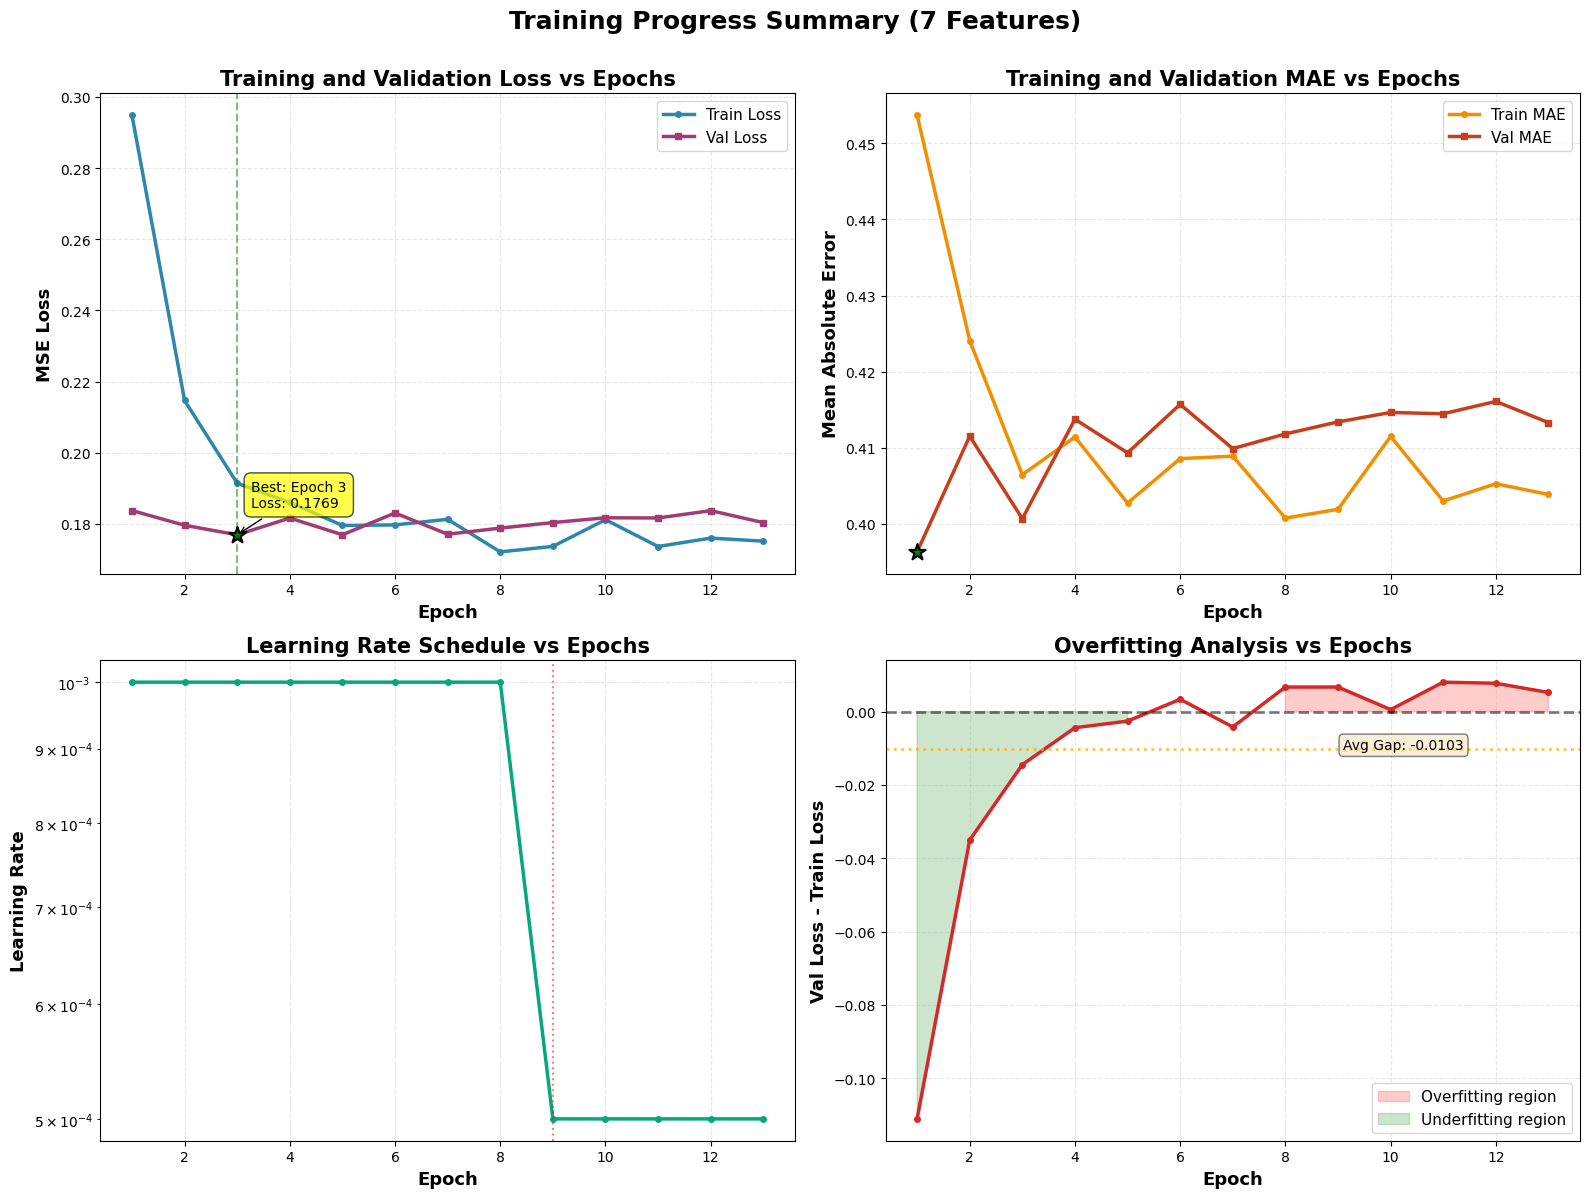

📈 Plots displayed above!

📈 FINAL SUMMARY
Best validation loss: 0.1769
Best validation MAE: 0.3963
Final train loss: 0.1752
Final val loss: 0.1804
Total epochs trained: 13

💡 To use the trained model:
   1. Load model: torch.load('argument_quality_ffn_7features.pth')
   2. Load normalization stats for inference
   3. Normalize input features before prediction
   4. Use only 7 features (no max_logprob, no min_logprob)

✅ Training complete!


In [32]:
"""
Complete FFN Training Loop - Modified for 7 Features
Trains the argument quality evaluation model without max_logprob and min_logprob
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from typing import Dict, List, Tuple
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os


# ============================================================
# Model (Updated for 7 features)
# ============================================================

class LogicEvaluationModel(nn.Module):
    def __init__(self, input_dim: int = 7, dropout_rate: float = 0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.LayerNorm(64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            
            nn.Linear(64, 32),
            nn.LayerNorm(32),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            
            nn.Linear(32, 16),
            nn.LayerNorm(16),
            nn.ReLU(),
            
            nn.Linear(16, 1)   # Linear output for regression
        )
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
    
    def forward(self, x):
        return self.net(x)


# ============================================================
# Feature Normalization (7 features)
# ============================================================

def normalize_features(features: torch.Tensor) -> Tuple[torch.Tensor, Dict]:
    """
    Normalize features with special handling for avg_logprob and avg_entropy
    
    Feature order (7 features total):
    0: avg_logprob         → Normalize (negative values)
    1: relevance_support   → Already 0-1, no normalization
    2: relevance_contra    → Already 0-1, no normalization
    3: similarity          → Already 0-1, no normalization
    4: confidence          → Already 0-1, no normalization
    5: repetition          → Already 0-1, no normalization
    6: avg_entropy         → Normalize (positive values)
    
    REMOVED: max_logprob (previously index 6)
    REMOVED: min_logprob (previously index 7)
    
    Returns:
        normalized_features, normalization_stats
    """
    
    normalized = features.clone()
    stats = {}
    
    # Feature 0: avg_logprob (typically -10 to 0)
    # Use min-max normalization to [0, 1]
    avg_logprob = features[:, 0]
    min_val = avg_logprob.min()
    max_val = avg_logprob.max()
    normalized[:, 0] = (avg_logprob - min_val) / (max_val - min_val + 1e-8)
    stats['avg_logprob'] = {'min': min_val.item(), 'max': max_val.item()}
    
    # Features 1-5: Already normalized to [0, 1], keep as is
    # (relevance_support, relevance_contra, similarity, confidence, repetition)
    
    # Feature 6: avg_entropy (typically 0 to 10)
    # Use min-max normalization to [0, 1]
    avg_entropy = features[:, 6]
    min_val = avg_entropy.min()
    max_val = avg_entropy.max()
    normalized[:, 6] = (avg_entropy - min_val) / (max_val - min_val + 1e-8)
    stats['avg_entropy'] = {'min': min_val.item(), 'max': max_val.item()}
    
    return normalized, stats


# ============================================================
# Feature Extraction (Remove max_logprob and min_logprob)
# ============================================================

def extract_7_features(features_9: torch.Tensor) -> torch.Tensor:
    """
    Extract 7 features from the original 9-feature tensor by removing
    max_logprob (index 6) and min_logprob (index 7).
    
    Original 9 features:
    0: avg_logprob
    1: relevance_support
    2: relevance_contra
    3: similarity
    4: confidence
    5: repetition
    6: max_logprob (REMOVE)
    7: min_logprob (REMOVE)
    8: avg_entropy
    
    New 7 features:
    0: avg_logprob
    1: relevance_support
    2: relevance_contra
    3: similarity
    4: confidence
    5: repetition
    6: avg_entropy (moved from index 8)
    """
    # Keep features [0-5] and [8], dropping [6] and [7]
    indices = [0, 1, 2, 3, 4, 5, 8]
    return features_9[:, indices]


# ============================================================
# Training Loop
# ============================================================

def train_ffn(
    data_path: str = "training_data.pt",
    save_path: str = "argument_quality_ffn.pth",
    batch_size: int = 32,
    epochs: int = 50,
    learning_rate: float = 0.001,
    val_split: float = 0.2,
    early_stopping: int = 10,
    input_dim: int = 7
):
    """
    Complete training pipeline with normalization (7 features)
    
    Args:
        data_path: Path to training data
        save_path: Where to save trained model
        batch_size: Batch size for training
        epochs: Maximum number of epochs
        learning_rate: Learning rate
        val_split: Validation split ratio
        early_stopping: Early stopping patience
        input_dim: Number of input features (7 for reduced feature set)
    """
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"🎯 Training on: {device}")
    print(f"📊 Input features: {input_dim}\n")
    
    # Load data
    print("📦 Loading data...")
    data = torch.load(data_path)
    
    # Extract features and labels
    features = torch.stack([item[0] for item in data])
    labels = torch.tensor([item[1] for item in data], dtype=torch.float32)
    
    print(f"   Loaded {len(data)} samples")
    print(f"   Original feature shape: {features.shape}")
    print(f"   Label shape: {labels.shape}")
    
    # Convert from 9 features to 7 features if needed
    if features.shape[1] == 9:
        print("\n🔧 Converting from 9 features to 7 features...")
        print("   Removing: max_logprob (index 6), min_logprob (index 7)")
        features = extract_7_features(features)
        print(f"   New feature shape: {features.shape}")
    elif features.shape[1] != input_dim:
        print(f"⚠️  Warning: Expected {input_dim} features, got {features.shape[1]}")
        print(f"   Adjusting input_dim to {features.shape[1]}")
        input_dim = features.shape[1]
    
    # Normalize features
    print("\n🔧 Normalizing features...")
    print("   Features to normalize:")
    print("   - Feature 0: avg_logprob")
    print("   - Feature 6: avg_entropy")
    print("   Features already normalized (0-1):")
    print("   - Features 1-5: relevance_support, relevance_contra, similarity, confidence, repetition")
    
    normalized_features, norm_stats = normalize_features(features)
    
    print("\n📊 Normalization Statistics:")
    for feature_name, stats in norm_stats.items():
        print(f"   {feature_name}:")
        print(f"      Original range: [{stats['min']:.4f}, {stats['max']:.4f}]")
        print(f"      Normalized to: [0, 1]")
    
    # Save normalization stats
    norm_stats_path = save_path.replace('.pth', '_norm_stats.pt')
    torch.save(norm_stats, norm_stats_path)
    print(f"\n💾 Normalization stats saved to: {norm_stats_path}")
    
    # Create dataset
    dataset = TensorDataset(normalized_features, labels)
    val_size = int(len(dataset) * val_split)
    train_size = len(dataset) - val_size
    
    train_dataset, val_dataset = random_split(
        dataset, 
        [train_size, val_size],
        generator=torch.Generator().manual_seed(42)  # Reproducibility
    )
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    print(f"\n📊 Data Split:")
    print(f"   Train: {train_size} samples ({len(train_loader)} batches)")
    print(f"   Val: {val_size} samples ({len(val_loader)} batches)")
    
    # Initialize model
    model = LogicEvaluationModel(input_dim=input_dim).to(device)
    
    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"\n🤖 Model Architecture:")
    print(f"   Input({input_dim}) → 64 → 32 → 16 → 1")
    print(f"   Total parameters: {total_params:,}")
    print(f"   Trainable parameters: {trainable_params:,}")
    print(f"   Model size: {total_params * 4 / (1024**2):.2f} MB")
    
    # Loss and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(
        model.parameters(), 
        lr=learning_rate, 
        weight_decay=0.01  # L2 regularization
    )
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='min', 
        patience=5, 
        factor=0.5
    )
    
    # Training history
    history = {
        'train_loss': [], 
        'val_loss': [], 
        'train_mae': [], 
        'val_mae': [],
        'learning_rates': []
    }
    best_val_loss = float('inf')
    patience_counter = 0
    
    print("\n" + "="*80)
    print("🚀 TRAINING STARTED")
    print("="*80 + "\n")
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss, train_mae = 0, 0
        
        for features_batch, labels_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            features_batch = features_batch.to(device)
            labels_batch = labels_batch.to(device).unsqueeze(1)
            
            optimizer.zero_grad()
            outputs = model(features_batch)
            loss = criterion(outputs, labels_batch)
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            
            optimizer.step()
            
            train_loss += loss.item()
            train_mae += torch.abs(outputs - labels_batch).mean().item()
        
        train_loss /= len(train_loader)
        train_mae /= len(train_loader)
        
        # Validation phase
        model.eval()
        val_loss, val_mae = 0, 0
        
        with torch.no_grad():
            for features_batch, labels_batch in val_loader:
                features_batch = features_batch.to(device)
                labels_batch = labels_batch.to(device).unsqueeze(1)
                
                outputs = model(features_batch)
                loss = criterion(outputs, labels_batch)
                
                val_loss += loss.item()
                val_mae += torch.abs(outputs - labels_batch).mean().item()
        
        val_loss /= len(val_loader)
        val_mae /= len(val_loader)
        
        # Update scheduler
        scheduler.step(val_loss)
        current_lr = optimizer.param_groups[0]['lr']
        
        # Record history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_mae'].append(train_mae)
        history['val_mae'].append(val_mae)
        history['learning_rates'].append(current_lr)
        
        # Print progress
        print(f"Epoch {epoch+1:3d}/{epochs} | "
              f"Train Loss: {train_loss:.4f} MAE: {train_mae:.4f} | "
              f"Val Loss: {val_loss:.4f} MAE: {val_mae:.4f} | "
              f"LR: {current_lr:.6f}")
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            
            # Save model with normalization stats
            torch.save({
                'model_state_dict': model.state_dict(),
                'input_dim': input_dim,
                'normalization_stats': norm_stats,
                'best_val_loss': best_val_loss,
                'epoch': epoch + 1
            }, save_path)
            
            print(f"   💾 Best model saved! (val_loss: {val_loss:.4f})")
        else:
            patience_counter += 1
            print(f"   ⏳ No improvement ({patience_counter}/{early_stopping})")
        
        # Early stopping
        if patience_counter >= early_stopping:
            print(f"\n⚠️  Early stopping triggered at epoch {epoch+1}")
            break
    
    print("\n" + "="*80)
    print("✅ TRAINING COMPLETED")
    print("="*80)
    print(f"Best validation loss: {best_val_loss:.4f}")
    print(f"Model saved to: {save_path}")
    print("="*80 + "\n")
    
    # Plot training history
    plot_training_history(history, save_path='training_history.png')
    
    return model, history, norm_stats


# ============================================================
# Visualization
# ============================================================

def plot_training_history(history: Dict, save_path: str = 'training_history.png'):
    """Plot training history with enhanced visualization"""
    
    print("\n📊 Generating training visualization plots...")
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    epochs = range(1, len(history['train_loss']) + 1)
    
    # ========================================
    # Plot 1: Training and Validation Loss
    # ========================================
    axes[0, 0].plot(epochs, history['train_loss'], 
                    label='Train Loss', linewidth=2.5, color='#2E86AB', marker='o', markersize=4)
    axes[0, 0].plot(epochs, history['val_loss'], 
                    label='Val Loss', linewidth=2.5, color='#A23B72', marker='s', markersize=4)
    axes[0, 0].set_xlabel('Epoch', fontsize=13, fontweight='bold')
    axes[0, 0].set_ylabel('MSE Loss', fontsize=13, fontweight='bold')
    axes[0, 0].set_title('Training and Validation Loss vs Epochs', fontsize=15, fontweight='bold')
    axes[0, 0].legend(fontsize=11, loc='best')
    axes[0, 0].grid(True, alpha=0.3, linestyle='--')
    
    # Mark best epoch
    best_epoch = np.argmin(history['val_loss']) + 1
    best_val_loss = min(history['val_loss'])
    axes[0, 0].axvline(x=best_epoch, color='green', linestyle='--', alpha=0.5, linewidth=1.5)
    axes[0, 0].scatter([best_epoch], [best_val_loss], color='green', s=150, zorder=5, 
                       marker='*', edgecolors='black', linewidths=1.5)
    axes[0, 0].annotate(f'Best: Epoch {best_epoch}\nLoss: {best_val_loss:.4f}',
                       xy=(best_epoch, best_val_loss), xytext=(10, 20),
                       textcoords='offset points', fontsize=10,
                       bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7),
                       arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
    
    # ========================================
    # Plot 2: Training and Validation MAE
    # ========================================
    axes[0, 1].plot(epochs, history['train_mae'], 
                    label='Train MAE', linewidth=2.5, color='#F18F01', marker='o', markersize=4)
    axes[0, 1].plot(epochs, history['val_mae'], 
                    label='Val MAE', linewidth=2.5, color='#C73E1D', marker='s', markersize=4)
    axes[0, 1].set_xlabel('Epoch', fontsize=13, fontweight='bold')
    axes[0, 1].set_ylabel('Mean Absolute Error', fontsize=13, fontweight='bold')
    axes[0, 1].set_title('Training and Validation MAE vs Epochs', fontsize=15, fontweight='bold')
    axes[0, 1].legend(fontsize=11, loc='best')
    axes[0, 1].grid(True, alpha=0.3, linestyle='--')
    
    # Mark best MAE
    best_mae_epoch = np.argmin(history['val_mae']) + 1
    best_val_mae = min(history['val_mae'])
    axes[0, 1].scatter([best_mae_epoch], [best_val_mae], color='green', s=150, zorder=5,
                       marker='*', edgecolors='black', linewidths=1.5)
    
    # ========================================
    # Plot 3: Learning Rate Schedule
    # ========================================
    axes[1, 0].plot(epochs, history['learning_rates'], 
                    linewidth=2.5, color='#06A77D', marker='o', markersize=4)
    axes[1, 0].set_xlabel('Epoch', fontsize=13, fontweight='bold')
    axes[1, 0].set_ylabel('Learning Rate', fontsize=13, fontweight='bold')
    axes[1, 0].set_title('Learning Rate Schedule vs Epochs', fontsize=15, fontweight='bold')
    axes[1, 0].set_yscale('log')
    axes[1, 0].grid(True, alpha=0.3, linestyle='--')
    
    # Add text annotation for LR changes
    lr_changes = []
    for i in range(1, len(history['learning_rates'])):
        if history['learning_rates'][i] != history['learning_rates'][i-1]:
            lr_changes.append(i+1)
    
    for epoch_num in lr_changes[:3]:  # Annotate first 3 LR changes
        axes[1, 0].axvline(x=epoch_num, color='red', linestyle=':', alpha=0.5, linewidth=1.5)
    
    # ========================================
    # Plot 4: Overfitting Analysis
    # ========================================
    gap = np.array(history['val_loss']) - np.array(history['train_loss'])
    axes[1, 1].plot(epochs, gap, linewidth=2.5, color='#D62828', marker='o', markersize=4)
    axes[1, 1].axhline(y=0, color='black', linestyle='--', alpha=0.5, linewidth=2)
    axes[1, 1].fill_between(epochs, 0, gap, where=(gap > 0), 
                            color='red', alpha=0.2, label='Overfitting region')
    axes[1, 1].fill_between(epochs, 0, gap, where=(gap <= 0), 
                            color='green', alpha=0.2, label='Underfitting region')
    axes[1, 1].set_xlabel('Epoch', fontsize=13, fontweight='bold')
    axes[1, 1].set_ylabel('Val Loss - Train Loss', fontsize=13, fontweight='bold')
    axes[1, 1].set_title('Overfitting Analysis vs Epochs', fontsize=15, fontweight='bold')
    axes[1, 1].legend(fontsize=11, loc='best')
    axes[1, 1].grid(True, alpha=0.3, linestyle='--')
    
    # Add average gap line
    avg_gap = np.mean(gap)
    axes[1, 1].axhline(y=avg_gap, color='orange', linestyle=':', alpha=0.7, linewidth=2)
    axes[1, 1].text(len(epochs)*0.7, avg_gap, f'Avg Gap: {avg_gap:.4f}',
                   fontsize=10, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # Overall figure title
    fig.suptitle('Training Progress Summary (7 Features)', fontsize=18, fontweight='bold', y=0.995)
    
    plt.tight_layout(rect=[0, 0, 1, 0.99])
    plt.savefig(save_path, dpi=200, bbox_inches='tight', facecolor='white')
    print(f"✅ Training plots saved to: {save_path}")
    
    # Display plot (will show in Jupyter/Colab)
    try:
        plt.show()
        print("📈 Plots displayed above!")
    except:
        print("💡 Open the saved image to view plots")
    finally:
        plt.close()


# ============================================================
# Main Execution
# ============================================================

if __name__ == "__main__":
    
    # Configuration
    CONFIG = {
        'data_path': "/kaggle/working/training_data.pt",
        'save_path': "logic_evaluation_model.pth",
        'batch_size': 32,
        'epochs': 50,
        'learning_rate': 0.001,
        'val_split': 0.2,
        'early_stopping': 10,
        'input_dim': 7  # Updated to 7 features (removed max_logprob and min_logprob)
    }
    
    print("🧠 FFN Training with 7 Features")
    print("="*80)
    print("\n📋 Configuration:")
    for key, value in CONFIG.items():
        print(f"   {key}: {value}")
    print("\n🔧 Feature Set (7 features):")
    print("   0: avg_logprob")
    print("   1: relevance_support")
    print("   2: relevance_contra")
    print("   3: similarity")
    print("   4: confidence")
    print("   5: repetition")
    print("   6: avg_entropy")
    print("\n❌ REMOVED:")
    print("   - max_logprob")
    print("   - min_logprob")
    print("="*80)
    
    # Train model
    model, history, norm_stats = train_ffn(**CONFIG)
    
    # Print final summary
    print("\n" + "="*80)
    print("📈 FINAL SUMMARY")
    print("="*80)
    print(f"Best validation loss: {min(history['val_loss']):.4f}")
    print(f"Best validation MAE: {min(history['val_mae']):.4f}")
    print(f"Final train loss: {history['train_loss'][-1]:.4f}")
    print(f"Final val loss: {history['val_loss'][-1]:.4f}")
    print(f"Total epochs trained: {len(history['train_loss'])}")
    print("="*80)
    
    print("\n💡 To use the trained model:")
    print("   1. Load model: torch.load('argument_quality_ffn_7features.pth')")
    print("   2. Load normalization stats for inference")
    print("   3. Normalize input features before prediction")
    print("   4. Use only 7 features (no max_logprob, no min_logprob)")
    print("\n✅ Training complete!")

🧠 Training Data Preparation Pipeline

📦 Loading IBM dataset...
✅ Dataset loaded successfully!
   Train samples: 20974
   Validation samples: 3208

🔁 Found existing checkpoint!
✅ Resuming from sample #120

🔧 Initializing Feature Extractor...
🚀 FeatureExtractor using device: cuda
📦 Loading NLI pipeline...


Device set to use cuda:0


📦 Loading similarity model...
📦 Initializing Model Provider...
📥 Loading Model Weights & Tokenizer...
📥 Loading tokenizer: mistralai/Mistral-7B-Instruct-v0.1
⚡ Enabling 4-bit quantization (NF4)...
🧠 Loading model to GPU...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

✅ Model loaded on: cuda:0
✅ FeatureExtractor ready!

🚀 Starting data preparation...
⚠️  This will take a while (LLM generation)

🔧 Processing 1000 samples...


  0%|          | 3/880 [00:26<2:07:22,  8.71s/it]


✅ Processed 123/1000
   Topic: We should adopt a multi-party system...
   Features: [-0.4527958631515503, 0.08133596181869507, 0.8316455483436584, 0.8414666652679443]
   Label: 0.862


  1%|          | 6/880 [00:51<2:05:16,  8.60s/it]


✅ Processed 126/1000
   Topic: We should adopt a multi-party system...
   Features: [-0.5750749707221985, 0.07325220108032227, 0.991061806678772, 0.8763254284858704]
   Label: 0.882


  1%|          | 9/880 [01:17<2:04:50,  8.60s/it]


✅ Processed 129/1000
   Topic: We should adopt a multi-party system...
   Features: [-0.1867866814136505, 0.005258321762084961, 0.9126885533332825, 0.8525461554527283]
   Label: 1.000


  1%|          | 10/880 [01:26<2:04:35,  8.59s/it]

💾 Saved intermediate data to /kaggle/working/training_data_final.pt


  1%|▏         | 12/880 [01:43<2:03:58,  8.57s/it]


✅ Processed 132/1000
   Topic: We should adopt a multi-party system...
   Features: [-0.48176103830337524, 0.03159719705581665, 0.9934706687927246, 0.8630313277244568]
   Label: 1.000


  2%|▏         | 15/880 [02:09<2:03:24,  8.56s/it]


✅ Processed 135/1000
   Topic: We should adopt a multi-party system...
   Features: [-0.4195431172847748, 0.035293519496917725, 0.9679946899414062, 0.8706502914428711]
   Label: 0.840


  2%|▏         | 18/880 [02:34<2:02:36,  8.53s/it]


✅ Processed 138/1000
   Topic: We should adopt a multi-party system...
   Features: [-0.4290846288204193, 0.006826341152191162, 0.8842408061027527, 0.8520773649215698]
   Label: 1.000


  2%|▏         | 20/880 [02:51<2:02:15,  8.53s/it]

💾 Saved intermediate data to /kaggle/working/training_data_final.pt


  2%|▏         | 21/880 [03:00<2:02:04,  8.53s/it]


✅ Processed 141/1000
   Topic: We should adopt a multi-party system...
   Features: [-0.3331235647201538, 0.17222917079925537, 0.9981570839881897, 0.8566523790359497]
   Label: 1.000


  3%|▎         | 24/880 [03:25<2:02:03,  8.56s/it]


✅ Processed 144/1000
   Topic: We should adopt a multi-party system...
   Features: [-0.4029507637023926, 0.014637589454650879, 0.793262779712677, 0.8513080477714539]
   Label: 1.000


  3%|▎         | 27/880 [03:51<2:01:21,  8.54s/it]


✅ Processed 147/1000
   Topic: We should adopt a multi-party system...
   Features: [-0.6650991439819336, 0.04231816530227661, 0.9977259039878845, 0.8845518231391907]
   Label: 0.891


  3%|▎         | 30/880 [04:17<2:00:52,  8.53s/it]


✅ Processed 150/1000
   Topic: We should adopt a multi-party system...
   Features: [-0.3596852719783783, 0.3850095868110657, 0.6842296719551086, 0.8421244621276855]
   Label: 0.881
💾 Saved intermediate data to /kaggle/working/training_data_final.pt


  4%|▍         | 33/880 [04:42<2:00:45,  8.55s/it]


✅ Processed 153/1000
   Topic: We should adopt a multi-party system...
   Features: [-1.1109037399291992, 0.007095158100128174, 0.9197246432304382, 0.8195750117301941]
   Label: 1.000


  4%|▍         | 36/880 [05:09<2:03:15,  8.76s/it]


✅ Processed 156/1000
   Topic: We should adopt a multi-party system...
   Features: [-0.18888555467128754, 0.07785004377365112, 0.9345801472663879, 0.8823674917221069]
   Label: -0.784


  4%|▍         | 39/880 [05:35<2:02:37,  8.75s/it]


✅ Processed 159/1000
   Topic: We should adopt a multi-party system...
   Features: [-0.457947313785553, 0.029318392276763916, 0.9384943842887878, 0.8386343121528625]
   Label: -0.756


  5%|▍         | 40/880 [05:44<2:02:30,  8.75s/it]

💾 Saved intermediate data to /kaggle/working/training_data_final.pt


  5%|▍         | 42/880 [06:01<2:01:41,  8.71s/it]


✅ Processed 162/1000
   Topic: We should adopt a multi-party system...
   Features: [-0.4056870937347412, 0.41888540983200073, 0.542773962020874, 0.8646172881126404]
   Label: 0.978


  5%|▌         | 45/880 [06:28<2:02:38,  8.81s/it]


✅ Processed 165/1000
   Topic: We should adopt a multi-party system...
   Features: [-0.26458704471588135, 0.32787859439849854, 0.9934923052787781, 0.8600805997848511]
   Label: 0.899


  5%|▌         | 48/880 [06:54<2:00:50,  8.71s/it]


✅ Processed 168/1000
   Topic: We should adopt a multi-party system...
   Features: [-0.30519354343414307, 0.07634913921356201, 0.9965709447860718, 0.8426775932312012]
   Label: 0.783


  6%|▌         | 50/880 [07:12<2:01:12,  8.76s/it]

💾 Saved intermediate data to /kaggle/working/training_data_final.pt


  6%|▌         | 51/880 [07:20<2:01:42,  8.81s/it]


✅ Processed 171/1000
   Topic: We should adopt a multi-party system...
   Features: [-0.42681753635406494, 0.004498302936553955, 0.7620624899864197, 0.8767174482345581]
   Label: 0.874


  6%|▌         | 54/880 [07:47<2:01:26,  8.82s/it]


✅ Processed 174/1000
   Topic: We should adopt a multi-party system...
   Features: [-0.49560216069221497, 0.40379512310028076, 0.9956455230712891, 0.8622675538063049]
   Label: -0.877


  6%|▋         | 57/880 [08:13<2:00:13,  8.77s/it]


✅ Processed 177/1000
   Topic: We should adopt a multi-party system...
   Features: [-0.32613039016723633, 0.05758863687515259, 0.9319058060646057, 0.877966046333313]
   Label: -0.888


  7%|▋         | 60/880 [08:39<1:59:21,  8.73s/it]


✅ Processed 180/1000
   Topic: We should adopt a multi-party system...
   Features: [-0.1713976114988327, 0.07459813356399536, 0.5848428606987, 0.8759260177612305]
   Label: 0.869
💾 Saved intermediate data to /kaggle/working/training_data_final.pt


  7%|▋         | 63/880 [09:06<1:59:20,  8.76s/it]


✅ Processed 183/1000
   Topic: We should adopt a multi-party system...
   Features: [-0.44697678089141846, 0.002407371997833252, 0.8487418293952942, 0.8624103665351868]
   Label: 0.909


  8%|▊         | 66/880 [09:32<1:59:11,  8.79s/it]


✅ Processed 186/1000
   Topic: We should adopt a multi-party system...
   Features: [-0.21923166513442993, 0.43015652894973755, 0.42755183577537537, 0.8671650886535645]
   Label: -0.952


  8%|▊         | 69/880 [09:59<1:59:27,  8.84s/it]


✅ Processed 189/1000
   Topic: We should adopt a multi-party system...
   Features: [-0.16859567165374756, 0.08692383766174316, 0.9922492504119873, 0.8603678941726685]
   Label: 1.000


  8%|▊         | 70/880 [10:08<1:59:58,  8.89s/it]

💾 Saved intermediate data to /kaggle/working/training_data_final.pt


  8%|▊         | 72/880 [10:25<1:59:32,  8.88s/it]


✅ Processed 192/1000
   Topic: We should adopt a multi-party system...
   Features: [-0.6237940788269043, 0.01872462034225464, 0.8715789914131165, 0.8840481638908386]
   Label: -0.742


  9%|▊         | 75/880 [10:52<1:58:53,  8.86s/it]


✅ Processed 195/1000
   Topic: We should adopt a multi-party system...
   Features: [-0.5505812764167786, 0.014809906482696533, 0.5481143593788147, 0.8713805079460144]
   Label: 1.000


  9%|▉         | 78/880 [11:19<1:59:27,  8.94s/it]


✅ Processed 198/1000
   Topic: We should adopt a multi-party system...
   Features: [-0.35087451338768005, 0.03859817981719971, 0.9680233001708984, 0.8599734306335449]
   Label: 0.856


  9%|▉         | 80/880 [11:37<1:59:18,  8.95s/it]

💾 Saved intermediate data to /kaggle/working/training_data_final.pt


  9%|▉         | 81/880 [11:46<1:59:16,  8.96s/it]


✅ Processed 201/1000
   Topic: We should adopt a multi-party system...
   Features: [-0.31680187582969666, 0.37242770195007324, 0.3979392647743225, 0.8682483434677124]
   Label: 1.000


 10%|▉         | 84/880 [12:13<1:58:43,  8.95s/it]


✅ Processed 204/1000
   Topic: We should adopt a multi-party system...
   Features: [-0.4244506061077118, 0.255038857460022, 0.5386112332344055, 0.8820977210998535]
   Label: -0.945


 10%|▉         | 87/880 [12:39<1:58:18,  8.95s/it]


✅ Processed 207/1000
   Topic: We should adopt a multi-party system...
   Features: [-0.21720309555530548, 0.0053119659423828125, 0.8148052096366882, 0.8585875034332275]
   Label: 1.000


 10%|█         | 90/880 [13:06<1:57:41,  8.94s/it]


✅ Processed 210/1000
   Topic: We should adopt a multi-party system...
   Features: [-0.3565211594104767, 0.17139476537704468, 0.6712011098861694, 0.867406964302063]
   Label: 0.906
💾 Saved intermediate data to /kaggle/working/training_data_final.pt


 11%|█         | 93/880 [13:33<1:57:09,  8.93s/it]


✅ Processed 213/1000
   Topic: We should adopt a multi-party system...
   Features: [-0.4976302981376648, 0.03975415229797363, 0.9925398230552673, 0.8629536032676697]
   Label: -0.864


 11%|█         | 96/880 [13:59<1:56:08,  8.89s/it]


✅ Processed 216/1000
   Topic: We should adopt a multi-party system...
   Features: [-0.3719491958618164, 0.4808322787284851, 0.9457263946533203, 0.8795273900032043]
   Label: 1.000


 11%|█▏        | 99/880 [14:26<1:55:58,  8.91s/it]


✅ Processed 219/1000
   Topic: We should adopt a multi-party system...
   Features: [-0.5440937876701355, 0.0022533535957336426, 0.8113287091255188, 0.8458796739578247]
   Label: 0.913


 11%|█▏        | 100/880 [14:35<1:54:58,  8.84s/it]

💾 Saved intermediate data to /kaggle/working/training_data_final.pt


 12%|█▏        | 102/880 [14:52<1:54:25,  8.83s/it]


✅ Processed 222/1000
   Topic: We should adopt a multi-party system...
   Features: [-0.6594061255455017, 0.030355393886566162, 0.9851039052009583, 0.8750126957893372]
   Label: 0.867


 12%|█▏        | 105/880 [15:19<1:54:29,  8.86s/it]


✅ Processed 225/1000
   Topic: We should adopt a multi-party system...
   Features: [-0.2661719024181366, 0.11431294679641724, 0.9260045886039734, 0.8500654697418213]
   Label: 0.895


 12%|█▏        | 108/880 [15:46<1:53:21,  8.81s/it]


✅ Processed 228/1000
   Topic: We should adopt a multi-party system...
   Features: [-0.4371623396873474, 0.14083778858184814, 0.8365084528923035, 0.8757102489471436]
   Label: -0.798


 12%|█▎        | 110/880 [16:03<1:52:38,  8.78s/it]

💾 Saved intermediate data to /kaggle/working/training_data_final.pt


 13%|█▎        | 111/880 [16:12<1:52:37,  8.79s/it]


✅ Processed 231/1000
   Topic: We should adopt a multi-party system...
   Features: [-0.5552223324775696, 0.28027892112731934, 0.9960302710533142, 0.843348503112793]
   Label: -0.492


 13%|█▎        | 114/880 [16:38<1:52:41,  8.83s/it]


✅ Processed 234/1000
   Topic: We should adopt a multi-party system...
   Features: [-0.27930140495300293, 0.37949055433273315, 0.8095735907554626, 0.8823840618133545]
   Label: 0.461


 13%|█▎        | 117/880 [17:05<1:51:45,  8.79s/it]


✅ Processed 237/1000
   Topic: We should adopt a multi-party system...
   Features: [-0.4539077877998352, 0.5034761428833008, 0.858193576335907, 0.8561791181564331]
   Label: 0.732


 14%|█▎        | 120/880 [17:31<1:51:37,  8.81s/it]


✅ Processed 240/1000
   Topic: Homeschooling should be banned...
   Features: [-0.40080299973487854, 0.5030491352081299, 0.9796922206878662, 0.9444800615310669]
   Label: -0.886
💾 Saved intermediate data to /kaggle/working/training_data_final.pt


 14%|█▍        | 123/880 [17:58<1:51:41,  8.85s/it]


✅ Processed 243/1000
   Topic: We should prohibit flag burning...
   Features: [-0.27654117345809937, 0.0206601619720459, 0.7375211119651794, 0.8447719812393188]
   Label: -0.870


 14%|█▍        | 126/880 [18:25<1:51:49,  8.90s/it]


✅ Processed 246/1000
   Topic: We should legalize prostitution...
   Features: [-0.42004668712615967, 0.17169439792633057, 0.9835020899772644, 0.8495800495147705]
   Label: 0.674


 15%|█▍        | 129/880 [18:51<1:50:44,  8.85s/it]


✅ Processed 249/1000
   Topic: We should abolish intellectual property rights...
   Features: [-0.5553562045097351, 0.002753734588623047, 0.9879688024520874, 0.9250011444091797]
   Label: -0.872


 15%|█▍        | 130/880 [19:00<1:50:30,  8.84s/it]

💾 Saved intermediate data to /kaggle/working/training_data_final.pt


 15%|█▌        | 132/880 [19:18<1:50:27,  8.86s/it]


✅ Processed 252/1000
   Topic: We should legalize polygamy...
   Features: [-0.5401152968406677, 0.015370428562164307, 0.5028719305992126, 0.815120279788971]
   Label: 0.511


 15%|█▌        | 135/880 [19:44<1:49:20,  8.81s/it]


✅ Processed 255/1000
   Topic: We should ban naturopathy...
   Features: [-0.4465693533420563, 0.00977414846420288, 0.9318400621414185, 0.845790445804596]
   Label: -0.832


 16%|█▌        | 138/880 [20:11<1:48:59,  8.81s/it]


✅ Processed 258/1000
   Topic: Assisted suicide should be a criminal offence...
   Features: [-0.4794822037220001, 0.10113656520843506, 0.9497128129005432, 0.8758272528648376]
   Label: -0.865


 16%|█▌        | 140/880 [20:28<1:49:14,  8.86s/it]

💾 Saved intermediate data to /kaggle/working/training_data_final.pt


 16%|█▌        | 141/880 [20:37<1:49:10,  8.86s/it]


✅ Processed 261/1000
   Topic: We should limit executive compensation...
   Features: [-0.4716612696647644, 0.00996023416519165, 0.9730445146560669, 0.8789761066436768]
   Label: -0.441


 16%|█▋        | 144/880 [21:04<1:47:59,  8.80s/it]


✅ Processed 264/1000
   Topic: We should subsidize student loans...
   Features: [-0.46918317675590515, 0.009289205074310303, 0.4368060231208801, 0.6377962231636047]
   Label: -0.662


 17%|█▋        | 147/880 [21:30<1:47:37,  8.81s/it]


✅ Processed 267/1000
   Topic: We should abandon marriage...
   Features: [-0.39898279309272766, 0.01711869239807129, 0.9569386839866638, 0.8103849291801453]
   Label: 0.541


 17%|█▋        | 150/880 [21:56<1:47:12,  8.81s/it]


✅ Processed 270/1000
   Topic: We should close Guantanamo Bay detention camp...
   Features: [-0.3075345754623413, 0.04888802766799927, 0.9639927744865417, 0.8119664192199707]
   Label: 0.568
💾 Saved intermediate data to /kaggle/working/training_data_final.pt


 17%|█▋        | 153/880 [22:23<1:46:25,  8.78s/it]


✅ Processed 273/1000
   Topic: We should abandon marriage...
   Features: [-0.6330344676971436, 0.0283968448638916, 0.9841700792312622, 0.8086147308349609]
   Label: 0.529


 18%|█▊        | 156/880 [22:49<1:45:29,  8.74s/it]


✅ Processed 276/1000
   Topic: We should abolish safe spaces...
   Features: [-0.40588557720184326, 0.007227957248687744, 0.6706612706184387, 0.8129199743270874]
   Label: 0.456


 18%|█▊        | 159/880 [23:15<1:45:11,  8.75s/it]


✅ Processed 279/1000
   Topic: We should limit judicial activism...
   Features: [-0.5441970229148865, 0.0035467147827148438, 0.8491920828819275, 0.815544605255127]
   Label: 0.876


 18%|█▊        | 160/880 [23:24<1:44:51,  8.74s/it]

💾 Saved intermediate data to /kaggle/working/training_data_final.pt


 18%|█▊        | 162/880 [23:41<1:44:24,  8.72s/it]


✅ Processed 282/1000
   Topic: We should abolish intellectual property rights...
   Features: [-0.20926810801029205, 0.03761929273605347, 0.8964576721191406, 0.7811315059661865]
   Label: -0.687


 19%|█▉        | 165/880 [24:07<1:44:12,  8.75s/it]


✅ Processed 285/1000
   Topic: We should subsidize student loans...
   Features: [-0.43127965927124023, 0.009278178215026855, 0.9774617552757263, 0.8992091417312622]
   Label: 0.766


 19%|█▉        | 168/880 [24:34<1:44:14,  8.78s/it]


✅ Processed 288/1000
   Topic: We should ban cosmetic surgery for minors...
   Features: [-0.7498292922973633, 0.16141200065612793, 0.8885565400123596, 0.8909369111061096]
   Label: -0.435


 19%|█▉        | 170/880 [24:52<1:44:26,  8.83s/it]

💾 Saved intermediate data to /kaggle/working/training_data_final.pt


 19%|█▉        | 171/880 [25:00<1:44:03,  8.81s/it]


✅ Processed 291/1000
   Topic: We should introduce compulsory voting...
   Features: [-0.24315404891967773, 0.32985782623291016, 0.7593607902526855, 0.8906077146530151]
   Label: 0.914


 20%|█▉        | 174/880 [25:27<1:43:41,  8.81s/it]


✅ Processed 294/1000
   Topic: We should ban cosmetic surgery for minors...
   Features: [-0.6679710745811462, 0.025538384914398193, 0.9757022857666016, 0.745556116104126]
   Label: -0.657


 20%|██        | 177/880 [25:53<1:43:51,  8.86s/it]


✅ Processed 297/1000
   Topic: We should legalize polygamy...
   Features: [-0.6355736255645752, 0.0054236650466918945, 0.9025388956069946, 0.8358479738235474]
   Label: -0.591


 20%|██        | 180/880 [26:20<1:42:45,  8.81s/it]


✅ Processed 300/1000
   Topic: We should stop the development of autonomous cars...
   Features: [-0.6485802531242371, 0.01455378532409668, 0.9074117541313171, 0.8621765375137329]
   Label: -0.725
💾 Saved intermediate data to /kaggle/working/training_data_final.pt


 21%|██        | 183/880 [26:46<1:41:15,  8.72s/it]


✅ Processed 303/1000
   Topic: The vow of celibacy should be abandoned...
   Features: [-0.4294024705886841, 0.053366899490356445, 0.8720884919166565, 0.8957840204238892]
   Label: -0.820


 21%|██        | 186/880 [27:12<1:40:13,  8.66s/it]


✅ Processed 306/1000
   Topic: The vow of celibacy should be abandoned...
   Features: [-0.4691517651081085, 0.0021411776542663574, 0.9101837277412415, 0.9143669605255127]
   Label: -0.787


 21%|██▏       | 189/880 [27:38<1:39:47,  8.67s/it]


✅ Processed 309/1000
   Topic: The vow of celibacy should be abandoned...
   Features: [-0.44856691360473633, 0.042691051959991455, 0.710720956325531, 0.931709885597229]
   Label: -0.923


 22%|██▏       | 190/880 [27:46<1:39:42,  8.67s/it]

💾 Saved intermediate data to /kaggle/working/training_data_final.pt


 22%|██▏       | 192/880 [28:04<1:39:38,  8.69s/it]


✅ Processed 312/1000
   Topic: Surrogacy should be banned...
   Features: [-0.4984305799007416, 0.5828297138214111, 0.757175862789154, 0.9522457122802734]
   Label: 0.901


 22%|██▏       | 195/880 [28:30<1:39:10,  8.69s/it]


✅ Processed 315/1000
   Topic: We should legalize prostitution...
   Features: [-0.47037965059280396, 0.05640453100204468, 0.9978151321411133, 0.9084879159927368]
   Label: 1.000


 22%|██▎       | 198/880 [28:56<1:38:16,  8.65s/it]


✅ Processed 318/1000
   Topic: We should legalize prostitution...
   Features: [-0.5141624212265015, 0.1269385814666748, 0.7638584971427917, 0.8888165950775146]
   Label: 0.873


 23%|██▎       | 200/880 [29:13<1:38:00,  8.65s/it]

💾 Saved intermediate data to /kaggle/working/training_data_final.pt


 23%|██▎       | 201/880 [29:22<1:37:49,  8.64s/it]


✅ Processed 321/1000
   Topic: We should abolish zoos...
   Features: [-0.4359382092952728, 0.0019649863243103027, 0.9236504435539246, 0.8122462630271912]
   Label: -0.800


 23%|██▎       | 204/880 [29:48<1:37:31,  8.66s/it]


✅ Processed 324/1000
   Topic: We should abolish zoos...
   Features: [-0.29278579354286194, 0.16382884979248047, 0.8567997217178345, 0.7944544553756714]
   Label: 0.889


 24%|██▎       | 207/880 [30:14<1:36:34,  8.61s/it]


✅ Processed 327/1000
   Topic: We should abandon marriage...
   Features: [-0.3888086974620819, 0.14397042989730835, 0.881151020526886, 0.7812128663063049]
   Label: 1.000


 24%|██▍       | 210/880 [30:40<1:36:32,  8.65s/it]


✅ Processed 330/1000
   Topic: We should abandon television...
   Features: [-0.3814820349216461, 0.013603806495666504, 0.880073606967926, 0.9421958923339844]
   Label: 0.837
💾 Saved intermediate data to /kaggle/working/training_data_final.pt


 24%|██▍       | 213/880 [31:06<1:36:38,  8.69s/it]


✅ Processed 333/1000
   Topic: We should abandon marriage...
   Features: [-0.5890091061592102, 0.06974852085113525, 0.9925610423088074, 0.776677668094635]
   Label: -0.846


 25%|██▍       | 216/880 [31:32<1:36:17,  8.70s/it]


✅ Processed 336/1000
   Topic: We should abolish capital punishment...
   Features: [-0.18718767166137695, 0.0069342851638793945, 0.7595805525779724, 0.8157620429992676]
   Label: -0.621


 25%|██▍       | 219/880 [31:58<1:35:16,  8.65s/it]


✅ Processed 339/1000
   Topic: We should abolish intellectual property rights...
   Features: [-0.5869628190994263, 0.05986124277114868, 0.7602731585502625, 0.7951058149337769]
   Label: 0.820


 25%|██▌       | 220/880 [32:06<1:34:56,  8.63s/it]

💾 Saved intermediate data to /kaggle/working/training_data_final.pt


 25%|██▌       | 222/880 [32:23<1:34:29,  8.62s/it]


✅ Processed 342/1000
   Topic: We should abolish intellectual property rights...
   Features: [-0.3836420178413391, 0.021851062774658203, 0.9489710330963135, 0.8417348861694336]
   Label: 1.000


 26%|██▌       | 225/880 [32:49<1:34:07,  8.62s/it]


✅ Processed 345/1000
   Topic: We should abolish intellectual property rights...
   Features: [-0.3621983826160431, 0.027416765689849854, 0.9084688425064087, 0.8469451069831848]
   Label: 0.554


 26%|██▌       | 228/880 [33:15<1:33:39,  8.62s/it]


✅ Processed 348/1000
   Topic: We should abolish intellectual property rights...
   Features: [-0.32750365138053894, 0.04465895891189575, 0.9780043363571167, 0.8318812847137451]
   Label: -0.935


 26%|██▌       | 230/880 [33:32<1:33:23,  8.62s/it]

💾 Saved intermediate data to /kaggle/working/training_data_final.pt


 26%|██▋       | 231/880 [33:41<1:33:17,  8.62s/it]


✅ Processed 351/1000
   Topic: We should end mandatory retirement...
   Features: [-0.443349152803421, 0.01640254259109497, 0.9332489371299744, 0.8773990869522095]
   Label: 0.907


 27%|██▋       | 234/880 [34:07<1:33:01,  8.64s/it]


✅ Processed 354/1000
   Topic: We should fight for the abolition of nuclear weapons...
   Features: [-0.5197766423225403, 0.37750428915023804, 0.7940929532051086, 0.7849522829055786]
   Label: -0.657


 27%|██▋       | 237/880 [34:33<1:32:25,  8.62s/it]


✅ Processed 357/1000
   Topic: We should fight for the abolition of nuclear weapons...
   Features: [-0.5288844704627991, 0.02843928337097168, 0.9372350573539734, 0.7898319959640503]
   Label: 0.817


 27%|██▋       | 240/880 [34:59<1:32:06,  8.64s/it]


✅ Processed 360/1000
   Topic: We should abolish safe spaces...
   Features: [-0.2709351181983948, 0.004822134971618652, 0.9973639845848083, 0.8214553594589233]
   Label: -0.795
💾 Saved intermediate data to /kaggle/working/training_data_final.pt


 28%|██▊       | 243/880 [35:25<1:31:31,  8.62s/it]


✅ Processed 363/1000
   Topic: We should abolish the right to keep and bear arms...
   Features: [-0.2463388890028, 0.008750319480895996, 0.932620108127594, 0.8293175101280212]
   Label: 1.000


 28%|██▊       | 246/880 [35:51<1:31:22,  8.65s/it]


✅ Processed 366/1000
   Topic: We should abolish intellectual property rights...
   Features: [-0.509438157081604, 0.025098204612731934, 0.9787086844444275, 0.789139986038208]
   Label: -0.805


 28%|██▊       | 249/880 [36:17<1:30:57,  8.65s/it]


✅ Processed 369/1000
   Topic: We should abolish capital punishment...
   Features: [-0.2197950780391693, 0.002694249153137207, 0.5600298047065735, 0.9041544198989868]
   Label: 0.901


 28%|██▊       | 250/880 [36:25<1:30:51,  8.65s/it]

💾 Saved intermediate data to /kaggle/working/training_data_final.pt


 29%|██▊       | 252/880 [36:42<1:30:12,  8.62s/it]


✅ Processed 372/1000
   Topic: We should prohibit flag burning...
   Features: [-0.7822414040565491, 0.015178024768829346, 0.9990776777267456, 0.9089559316635132]
   Label: 0.140


 29%|██▉       | 255/880 [37:08<1:29:24,  8.58s/it]


✅ Processed 375/1000
   Topic: We should subsidize vocational education...
   Features: [-0.4000518023967743, 0.02276027202606201, 0.9867434501647949, 0.849184513092041]
   Label: 1.000


 29%|██▉       | 258/880 [37:34<1:28:52,  8.57s/it]


✅ Processed 378/1000
   Topic: We should stop the development of autonomous cars...
   Features: [-0.4578671455383301, 0.4495745897293091, 0.6667963266372681, 0.8625420331954956]
   Label: -0.943


 30%|██▉       | 260/880 [37:51<1:28:24,  8.56s/it]

💾 Saved intermediate data to /kaggle/working/training_data_final.pt


 30%|██▉       | 261/880 [38:00<1:28:25,  8.57s/it]


✅ Processed 381/1000
   Topic: We should ban naturopathy...
   Features: [-0.31154465675354004, 0.03442585468292236, 0.7120203375816345, 0.8784179091453552]
   Label: 0.776


 30%|███       | 264/880 [38:25<1:27:57,  8.57s/it]


✅ Processed 384/1000
   Topic: We should ban the use of child actors...
   Features: [-0.4256831109523773, 0.00938570499420166, 0.9809269905090332, 0.8125399947166443]
   Label: -0.881


 30%|███       | 267/880 [38:51<1:27:21,  8.55s/it]


✅ Processed 387/1000
   Topic: We should ban the use of child actors...
   Features: [-0.8104574680328369, 0.0070667266845703125, 0.97651207447052, 0.8817421793937683]
   Label: -1.000


 31%|███       | 270/880 [39:17<1:27:21,  8.59s/it]


✅ Processed 390/1000
   Topic: We should ban the use of child actors...
   Features: [-0.41685935854911804, 0.009551465511322021, 0.972307026386261, 0.8471130132675171]
   Label: -0.738
💾 Saved intermediate data to /kaggle/working/training_data_final.pt


 31%|███       | 273/880 [39:43<1:26:56,  8.59s/it]


✅ Processed 393/1000
   Topic: We should ban the use of child actors...
   Features: [-0.5633054971694946, 0.26207149028778076, 0.8776168823242188, 0.9565814137458801]
   Label: 0.731


 31%|███▏      | 276/880 [40:08<1:26:40,  8.61s/it]


✅ Processed 396/1000
   Topic: We should limit judicial activism...
   Features: [-0.42675021290779114, 0.16516196727752686, 0.9949824810028076, 0.800022304058075]
   Label: 1.000


 32%|███▏      | 279/880 [40:34<1:26:04,  8.59s/it]


✅ Processed 399/1000
   Topic: We should oppose collectivism...
   Features: [-0.4478497803211212, 0.012991249561309814, 0.9877098798751831, 0.9018906354904175]
   Label: -0.764


 32%|███▏      | 280/880 [40:43<1:26:00,  8.60s/it]

💾 Saved intermediate data to /kaggle/working/training_data_final.pt


 32%|███▏      | 282/880 [41:00<1:25:50,  8.61s/it]


✅ Processed 402/1000
   Topic: We should ban cosmetic surgery for minors...
   Features: [-0.5032368302345276, 0.006032228469848633, 0.9043323993682861, 0.9128154516220093]
   Label: 0.871


 32%|███▏      | 285/880 [41:26<1:25:24,  8.61s/it]


✅ Processed 405/1000
   Topic: We should adopt an austerity regime...
   Features: [-0.4502691626548767, 0.00830453634262085, 0.9817926287651062, 0.8459904789924622]
   Label: -0.872


 33%|███▎      | 287/880 [41:43<1:24:41,  8.57s/it]Exception ignored in: <function _xla_gc_callback at 0x7c8833157880>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/jax/_src/lib/__init__.py", line 127, in _xla_gc_callback
    def _xla_gc_callback(*args):
    
KeyboardInterrupt: 
 33%|███▎      | 287/880 [41:45<1:26:16,  8.73s/it]


KeyboardInterrupt: 